In [1]:
from tardis import run_tardis
from tardis.visualization import SDECPlotter

from astropy.io import fits
import astropy.units as u
import numpy as np
import matplotlib.pyplot as plt

import matplotlib as mpl
from matplotlib.ticker import MultipleLocator
mpl.rcParams['text.usetex'] = True
mpl.rcParams['font.size'] = '25'
mpl.rcParams['xtick.labelsize'] = '20'
mpl.rcParams['ytick.labelsize'] = '20'

Iterations:          0/? [00:00<?, ?it/s]

Packets:             0/? [00:00<?, ?it/s]

In [2]:
joj1 = np.loadtxt("../spectroscopy/data/ZTF22aajijjf_20220511_FTN_FLOYDS-N_Global_SN_Project.ascii")
joj2 = np.loadtxt("../spectroscopy/data/ZTF22aajijjf_20220526_SEDM_1.txt")
from scipy.integrate import trapz

flux1 = trapz(joj1[:, 1], joj1[:, 0])
flux2 = trapz(joj2[:, 1], joj2[:, 0])
DL = (114.48 * u.Mpc).cgs.value
luminosity1 = (flux1 * 4 * np.pi * DL**2) / (1 * u.Lsun).cgs.value
luminosity2 = (flux2 * 4 * np.pi * DL**2) / (1 * u.Lsun).cgs.value
z = 0.02736
print('First spec:')
print('wv_min = {:.2f}, wv_max = {:.2f}'.format(joj1[0, 0]/(1+z), joj1[-1, 0]/(1+z)))
print('log L = {:.2f} log Lsun'.format(np.log10(luminosity1)))

print('Second spec:')
print('wv_min = {:.2f}, wv_max = {:.2f}'.format(joj2[0, 0]/(1+z), joj2[-1, 0]/(1+z)))
print('log L = {:.2f} log Lsun'.format(np.log10(luminosity2)))

First spec:
wv_min = 3407.22, wv_max = 9734.75
log L = 8.52 log Lsun
Second spec:
wv_min = 3676.12, wv_max = 8977.67
log L = 9.40 log Lsun


In [3]:
# from tardis.io.atom_data.util import download_atom_data
# download_atom_data('kurucz_cd23_chianti_H_He')

In [4]:
iso_title = np.array('H1  He4 C12  N14  O16  Ne20  Na23  Mg24  Al27  Si28  S32   Ar36  Ca40  Sc45  Ti48  V51   Cr52  Mn55  Fe56  Co59  Ni58  Ni56  Co56  Fe52  Cr48  V48   Mn52'.split())

In [5]:
# from wikipedia
tau_Ni56 = 6.077 / np.log(2)  # Ni-56 --> Co-56
tau_Co56 = 77.233 / np.log(2)  # Co-56 --> Fe-56

tau_Fe52 = 8.275 / 24 / np.log(2)  # Fe-52 --> Mn-52
tau_Mn52 = 21.1 / 60 / 24 / np.log(2)  # Mn-52 --> Cr-52

tau_Cr48 = 21.56 / 24 / np.log(2)  # Cr-48 --> V-48
tau_V48 = 15.9735 / np.log(2)  # V-48 --> Ti-48

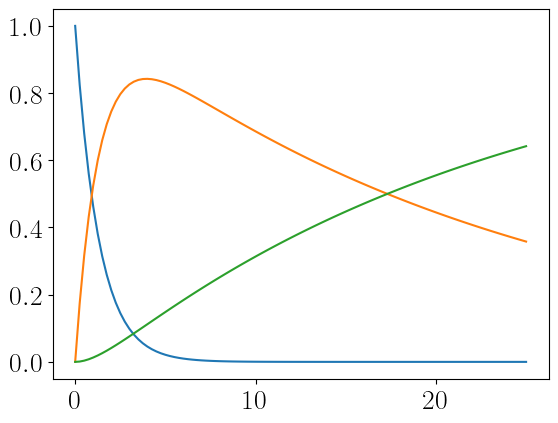

In [6]:
# radioactive decay
from scipy.integrate import odeint

time = np.linspace(0, 25, 101)


def decay_chain(tau1, tau2, n1, n2, n3, time):
    def deriv(A, t, Ab):
        return np.dot(Ab, A)

    Ab = np.array([[-1 / tau1,        0,  0], 
                   [1 / tau1, -1 / tau2,  0], 
                   [0,         1 / tau2,  0]])

    A0 = np.array([n1, n2, n3])

    MA = odeint(deriv, A0, time, args=(Ab,))
    MA = np.where(MA > 0, MA, 0)
    return MA


plt.plot(time, decay_chain(tau_Cr48, tau_V48, 1, 0, 0, time))


In [7]:
def load_profile(file="./Shen+2021/d14e5_m100_wedge_mu_00.txt"):
    with open(file, "r") as f:
        lines = [l for l in f.readlines() if l[0] != "!"]
    prof = []
    for l in lines[3:]:
        prof.append(np.array(l.split(), dtype=float))
    # dat = np.loadtxt('./doubledet_2021_m1003_1_isotopes.dat')
    prof = np.array(prof)
    prof[:, 0] = prof[:, 0] / 1e5  # cm/s --> km/s
    iso_dat = prof[:, 3:].copy()
    iso_dat0 = prof[:, 3:].copy()

    # Ni56 --> Co56 --> Fe56
    idx1 = np.argwhere(iso_title == "Ni56").ravel()[0]
    idx2 = np.argwhere(iso_title == "Co56").ravel()[0]
    idx3 = np.argwhere(iso_title == "Fe56").ravel()[0]

    t_post_exp = 17.5
    for k in range(len(prof)):
        iso_dat[k, idx1], iso_dat[k, idx2], iso_dat[k, idx3] = decay_chain(
            tau_Ni56,
            tau_Co56,
            iso_dat[k, idx1],
            iso_dat[k, idx2],
            iso_dat[k, idx3],
            np.array([0, t_post_exp]),
        )[-1]

    # Fe52 --> Mn52 --> Cr52
    idx1 = np.argwhere(iso_title == "Fe52").ravel()[0]
    idx2 = np.argwhere(iso_title == "Mn52").ravel()[0]
    idx3 = np.argwhere(iso_title == "Cr52").ravel()[0]
    for k in range(len(prof)):
        iso_dat[k, idx1], iso_dat[k, idx2], iso_dat[k, idx3] = decay_chain(
            tau_Fe52,
            tau_Mn52,
            iso_dat[k, idx1],
            iso_dat[k, idx2],
            iso_dat[k, idx3],
            np.array([0, t_post_exp]),
        )[-1]

    # Cr48 --> V48 --> Ti48
    idx1 = np.argwhere(iso_title == "Cr48").ravel()[0]
    idx2 = np.argwhere(iso_title == "V48").ravel()[0]
    idx3 = np.argwhere(iso_title == "Ti48").ravel()[0]
    for k in range(len(prof)):
        iso_dat[k, idx1], iso_dat[k, idx2], iso_dat[k, idx3] = decay_chain(
            tau_Cr48,
            tau_V48,
            iso_dat[k, idx1],
            iso_dat[k, idx2],
            iso_dat[k, idx3],
            np.array([0, t_post_exp]),
        )[-1]

    idx = np.max(iso_dat, axis=0) > 1e-1
    fig, ax = plt.subplots(1, 2, figsize=(16, 8), sharex=True)
    ax[0].plot(prof[:, 0], prof[:, 1])
    ax[0].set_yscale("log")
    ax[1].plot(prof[:, 0], iso_dat[:, idx], label=iso_title[idx])
    ax[1].legend(prop={"size": 15})
    ax[0].set_ylim(1e-4, 2)
    ax[1].set_xlim(0, 25000)
    ax[0].set_xlabel(r"$v\,[\mathrm{km}\,\mathrm{s}^{-1}]$")
    ax[1].set_xlabel(r"$v\,[\mathrm{km}\,\mathrm{s}^{-1}]$")
    ax[0].set_ylabel(r"$\rho\,[\mathrm{g}\,\mathrm{cm}^{-3}]$")
    ax[1].set_ylabel(r"$\mathrm{Mass\ fraction}$")
    fig.tight_layout()

    profile = np.append(prof[:, :2], iso_dat0, axis=1)
    return profile

In [8]:
def write_CSVY(fname, isotopes, profile, vmin=8000, vmax=28000, Ti_factor=1):
    lines = '''---
name: csvy_full
model_density_time_0: 0.0012 day
model_isotope_time_0: 0.0012 day
description: Example csvy config file for TARDIS.
tardis_model_config_version: v1.0
datatype:
  fields:
    -  name: velocity
       unit: km/s
       desc: velocities of shell outer bounderies.
    -  name: density
       unit: g/cm^3
       desc: density of shell.'''
    lines = [l + '\n' for l in lines.split('\n')]
    for i in isotopes:
        lines.append('    -  name: {}\n'.format(i))
        lines.append('       desc: fractional {} abundance.\n'.format(i))
    lines.append('---\n')
    lines.append(','.join(np.append('velocity,density', isotopes)) + '\n')

    iso_dat = profile[:, 2:].copy()

    # Ni56 --> Co56 --> Fe56
    # idx1 = np.argwhere(isotopes == "Ni56").ravel()[0]
    # idx2 = np.argwhere(isotopes == "Co56").ravel()[0]
    # idx3 = np.argwhere(isotopes == "Fe56").ravel()[0]
    # for k in range(len(prof)):
    #     iso_dat[k, idx1], iso_dat[k, idx2], iso_dat[k, idx3] = decay_chain(
    #         tau_Ni56,
    #         tau_Co56,
    #         iso_dat[k, idx1],
    #         iso_dat[k, idx2],
    #         iso_dat[k, idx3],
    #         np.array([0, time]),
    #     )[-1]

    # # Fe52 --> Mn52 --> Cr52
    # idx1 = np.argwhere(isotopes == "Fe52").ravel()[0]
    # idx2 = np.argwhere(isotopes == "Mn52").ravel()[0]
    # idx3 = np.argwhere(isotopes == "Cr52").ravel()[0]
    # for k in range(len(prof)):
    #     iso_dat[k, idx1], iso_dat[k, idx2], iso_dat[k, idx3] = decay_chain(
    #         tau_Fe52,
    #         tau_Mn52,
    #         iso_dat[k, idx1],
    #         iso_dat[k, idx2],
    #         iso_dat[k, idx3],
    #         np.array([0, time]),
    #     )[-1]

    # # Cr48 --> V48 --> Ti48
    # idx1 = np.argwhere(isotopes == "Cr48").ravel()[0]
    # idx2 = np.argwhere(isotopes == "V48").ravel()[0]
    # idx3 = np.argwhere(isotopes == "Ti48").ravel()[0]
    # for k in range(len(prof)):
    #     iso_dat[k, idx1], iso_dat[k, idx2], iso_dat[k, idx3] = decay_chain(
    #         tau_Cr48,
    #         tau_V48,
    #         iso_dat[k, idx1],
    #         iso_dat[k, idx2],
    #         iso_dat[k, idx3],
    #         np.array([0, time]),
    #     )[-1]

    # manually adjust Ti fraction
    idx = np.argwhere((isotopes == "Ti48") | (isotopes == "V48") | (isotopes == "Cr48")).ravel()
    iso_dat[:, idx] = iso_dat[:, idx] * Ti_factor

    profile = np.append(profile[:, :2], iso_dat, axis=1)
    
    for d in profile:
        if d[0] < vmin or d[0] > vmax:
            continue
        lines.append(','.join(['{:.5e}'.format(val) for val in d]) + '\n')

    with open(fname, 'w') as f:
        f.writelines(lines)

def write_config(fname, log_L, time, csvy_model):
    hdr = '''# Example YAML configuration for TARDIS
tardis_config_version: v1.0\n'''

    model = '''supernova:
  luminosity_requested: {:.2f} log_lsun
  time_explosion: {:.2f} day
  luminosity_wavelength_start: 3000 angstrom
  luminosity_wavelength_end: 10000 angstrom
atom_data: kurucz_cd23_chianti_H_He.h5

csvy_model: {}\n'''.format(log_L, time, csvy_model)

    simulation = '''plasma:
  disable_electron_scattering: no
  ionization: lte
  excitation: lte
  radiative_rates_type: dilute-blackbody
  line_interaction_type: macroatom

montecarlo:
  seed: 23111963
  no_of_packets: 4.0e+4
  iterations: 30
  nthreads: 1

  last_no_of_packets: 1.e+5
  no_of_virtual_packets: 10

  convergence_strategy:
    type: damped
    damping_constant: 1.0
    threshold: 0.05
    fraction: 0.8
    hold_iterations: 3
    t_inner:
      damping_constant: 0.1

spectrum:
  start: 500 angstrom
  stop: 20000 angstrom
  num: 10000'''
    
    with open(fname, 'w') as f:
        f.writelines(hdr + model + simulation)

## $\rho_5 = 14$

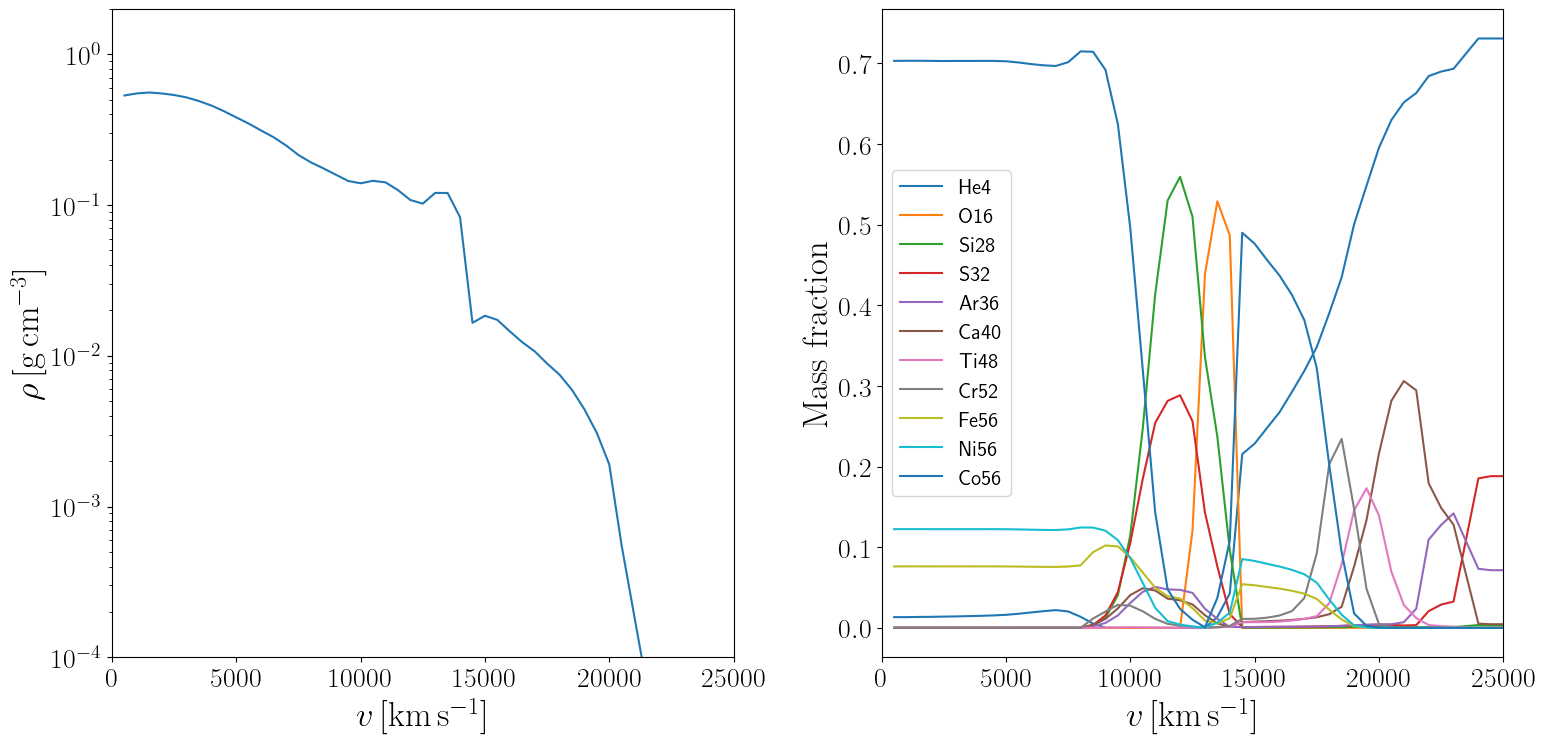

In [185]:
profile_14 = load_profile("./Shen+2021/d14e5_m100_wedge_mu_00.txt")

In [74]:
with open("./Shen+2021/d14e5_mu_0_phase_2.5_spec.txt") as f:
    l = f.readline()
    time = float(l.split("=")[-1])
    l = f.readline()
    log_L = float(l.split("=")[-1])
time

17.25

In [60]:
write_CSVY(
    "./d14e5_mu00_Ti0",
    isotopes=iso_title,
    profile=profile_14,
    vmin=12000,
    Ti_factor=0,
)
write_config(
    fname="tardis_Ti0.yml", log_L=log_L - 0.47, time=time, csvy_model="d14e5_mu00_Ti0"
)
sim0 = run_tardis(
    "tardis_Ti0.yml",
    virtual_packet_logging=True,
    show_convergence_plots=True,
    export_convergence_plots=True,
    log_level="INFO",
)

[tardis.model.base   ][WARNING]  
	Abundances have not been normalized to 1. - normalizing (base.py:892)
[tardis.plasma.standard_plasmas][INFO   ]  
	
	Reading Atomic Data from kurucz_cd23_chianti_H_He.h5 (standard_plasmas.py:95)
[tardis.io.atom_data.base][INFO   ]  
	Reading Atom Data with: UUID = 6f7b09e887a311e7a06b246e96350010 MD5  = 864f1753714343c41f99cb065710cace  (base.py:249)
[tardis.io.atom_data.base][INFO   ]  
	Non provided Atomic Data: synpp_refs, photoionization_data, yg_data, two_photon_data (base.py:253)
[py.warnings         ][WARNING]  
	/Users/chang/miniconda3/envs/tardis/lib/python3.8/site-packages/tardis/plasma/properties/radiative_properties.py:93: RuntimeWarning:

invalid value encountered in true_divide

 (warnings.py:109)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 1 of 20 (base.py:385)


TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:   ', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.500e+42 erg / s
	Luminosity absorbed  = 1.379e+42 erg / s
	Luminosity requested = 3.936e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,6.97e+03,7.38e+03,0.4,0.507
5,6.91e+03,7.05e+03,0.209,0.203
10,6.85e+03,6.51e+03,0.141,0.143
15,6.8e+03,5.07e+03,0.103,0.203
20,6.74e+03,4.92e+03,0.079,0.167
25,6.69e+03,4.85e+03,0.0627,0.137
30,6.63e+03,4.79e+03,0.0511,0.115


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 6971.134 K
	Expected t_inner for next iteration = 7403.192 K
 (base.py:554)


    'data': [{'type': 'scatter', 'uid': '39c6639b-9a6c-40f7-a8ae-d2267d74a28d', …

[tardis.simulation.base][INFO   ]  
	
	Starting iteration 2 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.787e+42 erg / s
	Luminosity absorbed  = 1.821e+42 erg / s
	Luminosity requested = 3.936e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,7.38e+03,7.83e+03,0.507,0.522
5,7.05e+03,7.72e+03,0.203,0.215
10,6.51e+03,7.14e+03,0.143,0.168
15,5.07e+03,5.37e+03,0.203,0.219
20,4.92e+03,4.87e+03,0.167,0.212
25,4.85e+03,4.78e+03,0.137,0.174
30,4.79e+03,4.72e+03,0.115,0.146


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7403.192 K
	Expected t_inner for next iteration = 7761.613 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 3 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 2.360e+42 erg / s
	Luminosity absorbed  = 1.998e+42 erg / s
	Luminosity requested = 3.936e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,7.83e+03,8.28e+03,0.522,0.496
5,7.72e+03,8.09e+03,0.215,0.195
10,7.14e+03,7.65e+03,0.168,0.149
15,5.37e+03,5.96e+03,0.219,0.187
20,4.87e+03,5.31e+03,0.212,0.188
25,4.78e+03,5.21e+03,0.174,0.155
30,4.72e+03,5.14e+03,0.146,0.131


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7761.613 K
	Expected t_inner for next iteration = 7987.737 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 4 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 2.970e+42 erg / s
	Luminosity absorbed  = 1.960e+42 erg / s
	Luminosity requested = 3.936e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.28e+03,8.6e+03,0.496,0.468
5,8.09e+03,8.25e+03,0.195,0.181
10,7.65e+03,7.83e+03,0.149,0.132
15,5.96e+03,6.23e+03,0.187,0.174
20,5.31e+03,5.71e+03,0.188,0.166
25,5.21e+03,5.62e+03,0.155,0.137
30,5.14e+03,5.54e+03,0.131,0.115


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7987.737 K
	Expected t_inner for next iteration = 8108.487 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 5 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.208e+42 erg / s
	Luminosity absorbed  = 1.974e+42 erg / s
	Luminosity requested = 3.936e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.6e+03,8.8e+03,0.468,0.453
5,8.25e+03,8.47e+03,0.181,0.175
10,7.83e+03,7.98e+03,0.132,0.129
15,6.23e+03,6.27e+03,0.174,0.175
20,5.71e+03,5.86e+03,0.166,0.16
25,5.62e+03,5.77e+03,0.137,0.132
30,5.54e+03,5.69e+03,0.115,0.111


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 8108.487 K
	Expected t_inner for next iteration = 8195.704 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 6 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.400e+42 erg / s
	Luminosity absorbed  = 1.987e+42 erg / s
	Luminosity requested = 3.936e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.8e+03,8.96e+03,0.453,0.441
5,8.47e+03,8.65e+03,0.175,0.168
10,7.98e+03,8.04e+03,0.129,0.128
15,6.27e+03,6.39e+03,0.175,0.173
20,5.86e+03,5.95e+03,0.16,0.159
25,5.77e+03,5.85e+03,0.132,0.131
30,5.69e+03,5.78e+03,0.111,0.111


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 8195.704 K
	Expected t_inner for next iteration = 8257.916 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 7 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.544e+42 erg / s
	Luminosity absorbed  = 2.002e+42 erg / s
	Luminosity requested = 3.936e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.96e+03,9.05e+03,0.441,0.437
5,8.65e+03,8.9e+03,0.168,0.161
10,8.04e+03,8.38e+03,0.128,0.118
15,6.39e+03,6.43e+03,0.173,0.173
20,5.95e+03,6.03e+03,0.159,0.156
25,5.85e+03,5.93e+03,0.131,0.129
30,5.78e+03,5.86e+03,0.111,0.109


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 8257.916 K
	Expected t_inner for next iteration = 8302.319 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 8 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.654e+42 erg / s
	Luminosity absorbed  = 1.972e+42 erg / s
	Luminosity requested = 3.936e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.05e+03,9.11e+03,0.437,0.435
5,8.9e+03,9.05e+03,0.161,0.155
10,8.38e+03,8.52e+03,0.118,0.113
15,6.43e+03,6.59e+03,0.173,0.162
20,6.03e+03,6.15e+03,0.156,0.149
25,5.93e+03,6.05e+03,0.129,0.123
30,5.86e+03,5.97e+03,0.109,0.103


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 8302.319 K
	Expected t_inner for next iteration = 8333.692 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 9 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.741e+42 erg / s
	Luminosity absorbed  = 1.990e+42 erg / s
	Luminosity requested = 3.936e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.11e+03,9.12e+03,0.435,0.433
5,9.05e+03,9.31e+03,0.155,0.144
10,8.52e+03,8.65e+03,0.113,0.109
15,6.59e+03,6.7e+03,0.162,0.154
20,6.15e+03,6.29e+03,0.149,0.139
25,6.05e+03,6.19e+03,0.123,0.115
30,5.97e+03,6.11e+03,0.103,0.0968


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 8333.692 K
	Expected t_inner for next iteration = 8355.041 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 10 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.791e+42 erg / s
	Luminosity absorbed  = 1.962e+42 erg / s
	Luminosity requested = 3.936e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 1/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.12e+03,9.13e+03,0.433,0.438
5,9.31e+03,9.21e+03,0.144,0.149
10,8.65e+03,8.68e+03,0.109,0.108
15,6.7e+03,6.67e+03,0.154,0.158
20,6.29e+03,6.32e+03,0.139,0.139
25,6.19e+03,6.22e+03,0.115,0.114
30,6.11e+03,6.14e+03,0.0968,0.0964


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 8355.041 K
	Expected t_inner for next iteration = 8370.835 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 11 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.830e+42 erg / s
	Luminosity absorbed  = 1.971e+42 erg / s
	Luminosity requested = 3.936e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 2/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.13e+03,9.16e+03,0.438,0.437
5,9.21e+03,9.25e+03,0.149,0.148
10,8.68e+03,8.66e+03,0.108,0.11
15,6.67e+03,6.68e+03,0.158,0.158
20,6.32e+03,6.32e+03,0.139,0.139
25,6.22e+03,6.22e+03,0.114,0.115
30,6.14e+03,6.14e+03,0.0964,0.0968


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 8370.835 K
	Expected t_inner for next iteration = 8382.243 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 12 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.811e+42 erg / s
	Luminosity absorbed  = 2.002e+42 erg / s
	Luminosity requested = 3.936e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 3/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.16e+03,9.24e+03,0.437,0.424
5,9.25e+03,9.34e+03,0.148,0.144
10,8.66e+03,8.73e+03,0.11,0.106
15,6.68e+03,6.75e+03,0.158,0.151
20,6.32e+03,6.37e+03,0.139,0.135
25,6.22e+03,6.27e+03,0.115,0.111
30,6.14e+03,6.19e+03,0.0968,0.0935


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 8382.243 K
	Expected t_inner for next iteration = 8395.848 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 13 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.871e+42 erg / s
	Luminosity absorbed  = 1.963e+42 erg / s
	Luminosity requested = 3.936e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 4/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.24e+03,9.22e+03,0.424,0.43
5,9.34e+03,9.32e+03,0.144,0.146
10,8.73e+03,8.73e+03,0.106,0.107
15,6.75e+03,6.73e+03,0.151,0.155
20,6.37e+03,6.35e+03,0.135,0.138
25,6.27e+03,6.25e+03,0.111,0.114
30,6.19e+03,6.17e+03,0.0935,0.0961


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 8395.848 K
	Expected t_inner for next iteration = 8402.876 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 14 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.880e+42 erg / s
	Luminosity absorbed  = 1.963e+42 erg / s
	Luminosity requested = 3.936e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 5/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.22e+03,9.23e+03,0.43,0.426
5,9.32e+03,9.33e+03,0.146,0.148
10,8.73e+03,8.78e+03,0.107,0.108
15,6.73e+03,6.71e+03,0.155,0.159
20,6.35e+03,6.35e+03,0.138,0.14
25,6.25e+03,6.25e+03,0.114,0.115
30,6.17e+03,6.17e+03,0.0961,0.0968


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 8402.876 K
	Expected t_inner for next iteration = 8408.827 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 15 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.864e+42 erg / s
	Luminosity absorbed  = 2.037e+42 erg / s
	Luminosity requested = 3.936e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 6/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.23e+03,9.21e+03,0.426,0.438
5,9.33e+03,9.32e+03,0.148,0.146
10,8.78e+03,8.75e+03,0.108,0.107
15,6.71e+03,6.75e+03,0.159,0.154
20,6.35e+03,6.36e+03,0.14,0.137
25,6.25e+03,6.26e+03,0.115,0.113
30,6.17e+03,6.18e+03,0.0968,0.0954


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 8408.827 K
	Expected t_inner for next iteration = 8416.628 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 16 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.873e+42 erg / s
	Luminosity absorbed  = 2.016e+42 erg / s
	Luminosity requested = 3.936e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 7/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.21e+03,9.25e+03,0.438,0.428
5,9.32e+03,9.39e+03,0.146,0.142
10,8.75e+03,8.72e+03,0.107,0.108
15,6.75e+03,6.72e+03,0.154,0.155
20,6.36e+03,6.38e+03,0.137,0.135
25,6.26e+03,6.28e+03,0.113,0.111
30,6.18e+03,6.21e+03,0.0954,0.0938


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 8416.628 K
	Expected t_inner for next iteration = 8423.369 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 17 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.885e+42 erg / s
	Luminosity absorbed  = 2.009e+42 erg / s
	Luminosity requested = 3.936e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 8/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.25e+03,9.3e+03,0.428,0.423
5,9.39e+03,9.3e+03,0.142,0.147
10,8.72e+03,8.75e+03,0.108,0.107
15,6.72e+03,6.74e+03,0.155,0.155
20,6.38e+03,6.37e+03,0.135,0.137
25,6.28e+03,6.27e+03,0.111,0.113
30,6.21e+03,6.19e+03,0.0938,0.0952


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 8423.369 K
	Expected t_inner for next iteration = 8428.874 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 18 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.889e+42 erg / s
	Luminosity absorbed  = 2.018e+42 erg / s
	Luminosity requested = 3.936e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 9/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.3e+03,9.31e+03,0.423,0.422
5,9.3e+03,9.33e+03,0.147,0.146
10,8.75e+03,8.72e+03,0.107,0.108
15,6.74e+03,6.75e+03,0.155,0.154
20,6.37e+03,6.36e+03,0.137,0.138
25,6.27e+03,6.26e+03,0.113,0.114
30,6.19e+03,6.18e+03,0.0952,0.0964


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 8428.874 K
	Expected t_inner for next iteration = 8433.880 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 19 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.904e+42 erg / s
	Luminosity absorbed  = 2.019e+42 erg / s
	Luminosity requested = 3.936e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 10/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.31e+03,9.31e+03,0.422,0.424
5,9.33e+03,9.49e+03,0.146,0.141
10,8.72e+03,8.69e+03,0.108,0.109
15,6.75e+03,6.75e+03,0.154,0.155
20,6.36e+03,6.37e+03,0.138,0.138
25,6.26e+03,6.27e+03,0.114,0.113
30,6.18e+03,6.19e+03,0.0964,0.0955


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 8433.880 K
	Expected t_inner for next iteration = 8437.284 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 20 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.942e+42 erg / s
	Luminosity absorbed  = 1.987e+42 erg / s
	Luminosity requested = 3.936e+42 erg / s
 (base.py:559)


[tardis.simulation.base][INFO   ]  
	
	Simulation finished in 20 iterations 
	Simulation took 129.99 s
 (base.py:480)


[py.warnings         ][WARNING]  
	/Users/chang/miniconda3/envs/tardis/lib/python3.8/site-packages/astropy/units/quantity.py:1247: AstropyDeprecationWarning:

The truth value of a Quantity is ambiguous. In the future this will raise a ValueError.

 (warnings.py:109)


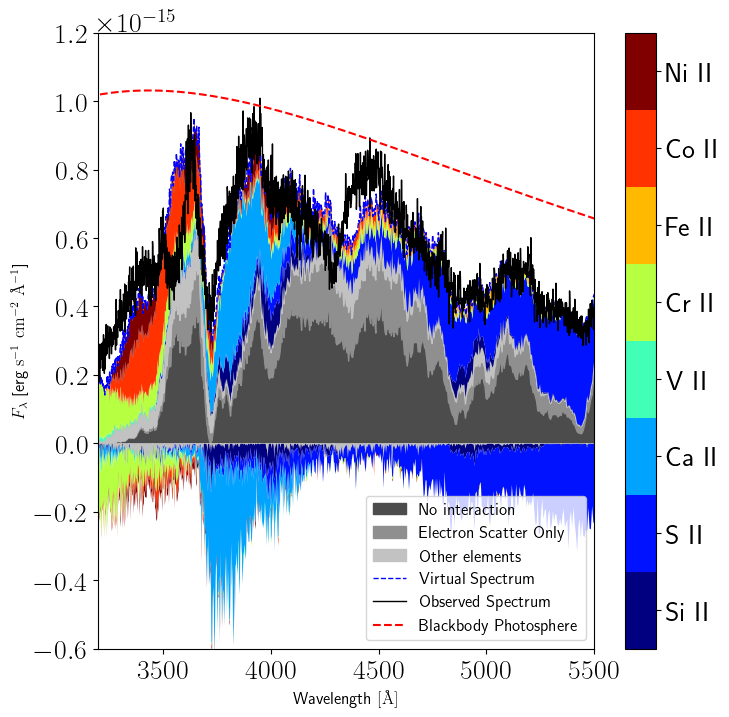

In [61]:
fig, ax = plt.subplots(figsize=(8, 8))
plotter0 = SDECPlotter.from_simulation(sim0)
# 2D SEDONA simulation
syn_dat = np.loadtxt("./Shen+2021/d14e5_mu_0_phase_0.0_spec.txt")
plotter0.generate_plot_mpl(
    packet_wvl_range=[3200, 5500] * u.AA,
    observed_spectrum=(
        syn_dat[:, 0] * u.AA,
        syn_dat[:, 1] * u.erg / u.cm**2 / u.s / u.AA / 4,
    ),
    # observed_spectrum=(
    #     joj2[:, 0] / (1 + z) * u.AA,
    #     joj2[:, 1] * (1 + z) * u.erg / u.cm**2 / u.s / u.AA / 4,
    # ),
    distance=114.48 * u.Mpc,
    species_list=["Si II", "S II", "Ca II", "Ti II", "V II", "Cr II", "Fe II", "Ni II", "Co II"],
    ax=ax
)
ax.legend(loc=4, prop={"size":12})
ax.set_ylim([-.6e-15, 1.2e-15])
ax.set_xlim(3200, 5500)
plt.show()

In [80]:
write_CSVY(
    "./d14e5_mu00_Ti1",
    isotopes=iso_title,
    profile=profile_14,
    vmin=13000,
    Ti_factor=1,
)
write_config(
    fname="tardis_Ti1.yml", log_L=log_L - 0.4, time=time, csvy_model="d14e5_mu00_Ti1"
)
sim1 = run_tardis(
    "tardis_Ti1.yml",
    virtual_packet_logging=True,
    show_convergence_plots=True,
    export_convergence_plots=True,
    log_level="INFO",
)
plotter1 = SDECPlotter.from_simulation(sim1)

[tardis.model.base   ][WARNING]  
	Abundances have not been normalized to 1. - normalizing (base.py:892)
[tardis.plasma.standard_plasmas][INFO   ]  
	
	Reading Atomic Data from kurucz_cd23_chianti_H_He.h5 (standard_plasmas.py:95)
[tardis.io.atom_data.base][INFO   ]  
	Reading Atom Data with: UUID = 6f7b09e887a311e7a06b246e96350010 MD5  = 864f1753714343c41f99cb065710cace  (base.py:249)
[tardis.io.atom_data.base][INFO   ]  
	Non provided Atomic Data: synpp_refs, photoionization_data, yg_data, two_photon_data (base.py:253)
[py.warnings         ][WARNING]  
	/Users/chang/miniconda3/envs/tardis/lib/python3.8/site-packages/tardis/plasma/properties/radiative_properties.py:93: RuntimeWarning:

invalid value encountered in true_divide

 (warnings.py:109)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 1 of 20 (base.py:385)


TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:   ', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.820e+42 erg / s
	Luminosity absorbed  = 1.352e+42 erg / s
	Luminosity requested = 4.416e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,6.37e+03,6.9e+03,0.403,0.427
5,6.32e+03,6.37e+03,0.218,0.224
10,6.26e+03,5.69e+03,0.149,0.189
15,6.21e+03,4.59e+03,0.11,0.252
20,6.16e+03,4.5e+03,0.0855,0.206
25,6.11e+03,4.44e+03,0.0684,0.171


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 6374.173 K
	Expected t_inner for next iteration = 6729.527 K
 (base.py:554)


    'data': [{'type': 'scatter', 'uid': '9a85d9d7-58e2-4c5f-a8a3-3bd44a3cdc7b', …

[tardis.simulation.base][INFO   ]  
	
	Starting iteration 2 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 2.030e+42 erg / s
	Luminosity absorbed  = 1.848e+42 erg / s
	Luminosity requested = 4.416e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,6.9e+03,7.37e+03,0.427,0.433
5,6.37e+03,6.87e+03,0.224,0.258
10,5.69e+03,6.21e+03,0.189,0.232
15,4.59e+03,4.63e+03,0.252,0.304
20,4.5e+03,4.41e+03,0.206,0.261
25,4.44e+03,4.34e+03,0.171,0.216


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 6729.527 K
	Expected t_inner for next iteration = 7049.045 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 3 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 2.742e+42 erg / s
	Luminosity absorbed  = 2.029e+42 erg / s
	Luminosity requested = 4.416e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,7.37e+03,7.86e+03,0.433,0.401
5,6.87e+03,7.46e+03,0.258,0.221
10,6.21e+03,6.92e+03,0.232,0.184
15,4.63e+03,5.03e+03,0.304,0.274
20,4.41e+03,4.73e+03,0.261,0.244
25,4.34e+03,4.65e+03,0.216,0.202


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7049.045 K
	Expected t_inner for next iteration = 7238.625 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 4 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.607e+42 erg / s
	Luminosity absorbed  = 1.743e+42 erg / s
	Luminosity requested = 4.416e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,7.86e+03,8.12e+03,0.401,0.368
5,7.46e+03,7.81e+03,0.221,0.186
10,6.92e+03,7.41e+03,0.184,0.147
15,5.03e+03,5.53e+03,0.274,0.223
20,4.73e+03,5.25e+03,0.244,0.197
25,4.65e+03,5.16e+03,0.202,0.164


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7238.625 K
	Expected t_inner for next iteration = 7315.702 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 5 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 4.122e+42 erg / s
	Luminosity absorbed  = 1.535e+42 erg / s
	Luminosity requested = 4.416e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.12e+03,8.2e+03,0.368,0.353
5,7.81e+03,7.69e+03,0.186,0.184
10,7.41e+03,7.16e+03,0.147,0.15
15,5.53e+03,5.77e+03,0.223,0.201
20,5.25e+03,5.56e+03,0.197,0.172
25,5.16e+03,5.48e+03,0.164,0.143


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7315.702 K
	Expected t_inner for next iteration = 7341.310 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 6 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 4.086e+42 erg / s
	Luminosity absorbed  = 1.601e+42 erg / s
	Luminosity requested = 4.416e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 1/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.2e+03,8.31e+03,0.353,0.347
5,7.69e+03,7.84e+03,0.184,0.181
10,7.16e+03,7.26e+03,0.15,0.149
15,5.77e+03,5.7e+03,0.201,0.21
20,5.56e+03,5.52e+03,0.172,0.177
25,5.48e+03,5.44e+03,0.143,0.148


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7341.310 K
	Expected t_inner for next iteration = 7370.369 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 7 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 4.237e+42 erg / s
	Luminosity absorbed  = 1.540e+42 erg / s
	Luminosity requested = 4.416e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 2/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.31e+03,8.35e+03,0.347,0.339
5,7.84e+03,7.94e+03,0.181,0.176
10,7.26e+03,7.4e+03,0.149,0.143
15,5.7e+03,5.76e+03,0.21,0.208
20,5.52e+03,5.58e+03,0.177,0.175
25,5.44e+03,5.5e+03,0.148,0.145


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7370.369 K
	Expected t_inner for next iteration = 7385.733 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 8 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 4.336e+42 erg / s
	Luminosity absorbed  = 1.492e+42 erg / s
	Luminosity requested = 4.416e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 3/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.35e+03,8.41e+03,0.339,0.335
5,7.94e+03,7.94e+03,0.176,0.175
10,7.4e+03,7.38e+03,0.143,0.145
15,5.76e+03,5.82e+03,0.208,0.203
20,5.58e+03,5.64e+03,0.175,0.171
25,5.5e+03,5.56e+03,0.145,0.142


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7385.733 K
	Expected t_inner for next iteration = 7392.509 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 9 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 4.375e+42 erg / s
	Luminosity absorbed  = 1.484e+42 erg / s
	Luminosity requested = 4.416e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 4/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.41e+03,8.37e+03,0.335,0.339
5,7.94e+03,8e+03,0.175,0.171
10,7.38e+03,7.36e+03,0.145,0.144
15,5.82e+03,5.82e+03,0.203,0.202
20,5.64e+03,5.66e+03,0.171,0.169
25,5.56e+03,5.58e+03,0.142,0.14


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7392.509 K
	Expected t_inner for next iteration = 7395.951 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 10 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 4.402e+42 erg / s
	Luminosity absorbed  = 1.487e+42 erg / s
	Luminosity requested = 4.416e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 5/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.37e+03,8.37e+03,0.339,0.342
5,8e+03,8.02e+03,0.171,0.171
10,7.36e+03,7.34e+03,0.144,0.148
15,5.82e+03,5.82e+03,0.202,0.204
20,5.66e+03,5.65e+03,0.169,0.171
25,5.58e+03,5.57e+03,0.14,0.142


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7395.951 K
	Expected t_inner for next iteration = 7397.099 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 11 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 4.397e+42 erg / s
	Luminosity absorbed  = 1.489e+42 erg / s
	Luminosity requested = 4.416e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 6/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.37e+03,8.36e+03,0.342,0.343
5,8.02e+03,8.01e+03,0.171,0.173
10,7.34e+03,7.42e+03,0.148,0.144
15,5.82e+03,5.85e+03,0.204,0.201
20,5.65e+03,5.66e+03,0.171,0.17
25,5.57e+03,5.58e+03,0.142,0.142


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7397.099 K
	Expected t_inner for next iteration = 7398.691 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 12 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 4.425e+42 erg / s
	Luminosity absorbed  = 1.470e+42 erg / s
	Luminosity requested = 4.416e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 7/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.36e+03,8.36e+03,0.343,0.342
5,8.01e+03,8.04e+03,0.173,0.167
10,7.42e+03,7.36e+03,0.144,0.144
15,5.85e+03,5.89e+03,0.201,0.194
20,5.66e+03,5.72e+03,0.17,0.163
25,5.58e+03,5.64e+03,0.142,0.136


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7398.691 K
	Expected t_inner for next iteration = 7397.942 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 13 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 4.396e+42 erg / s
	Luminosity absorbed  = 1.485e+42 erg / s
	Luminosity requested = 4.416e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 8/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.36e+03,8.36e+03,0.342,0.34
5,8.04e+03,7.92e+03,0.167,0.176
10,7.36e+03,7.27e+03,0.144,0.15
15,5.89e+03,5.83e+03,0.194,0.202
20,5.72e+03,5.66e+03,0.163,0.17
25,5.64e+03,5.58e+03,0.136,0.141


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7397.942 K
	Expected t_inner for next iteration = 7399.610 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 14 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 4.369e+42 erg / s
	Luminosity absorbed  = 1.484e+42 erg / s
	Luminosity requested = 4.416e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 9/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.36e+03,8.37e+03,0.34,0.34
5,7.92e+03,8.02e+03,0.176,0.172
10,7.27e+03,7.37e+03,0.15,0.148
15,5.83e+03,5.8e+03,0.202,0.206
20,5.66e+03,5.63e+03,0.17,0.173
25,5.58e+03,5.55e+03,0.141,0.144


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7399.610 K
	Expected t_inner for next iteration = 7403.552 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 15 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 4.429e+42 erg / s
	Luminosity absorbed  = 1.491e+42 erg / s
	Luminosity requested = 4.416e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 10/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.37e+03,8.37e+03,0.34,0.342
5,8.02e+03,7.9e+03,0.172,0.179
10,7.37e+03,7.38e+03,0.148,0.145
15,5.8e+03,5.86e+03,0.206,0.2
20,5.63e+03,5.67e+03,0.173,0.169
25,5.55e+03,5.59e+03,0.144,0.14


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7403.552 K
	Expected t_inner for next iteration = 7402.442 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 16 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 4.391e+42 erg / s
	Luminosity absorbed  = 1.502e+42 erg / s
	Luminosity requested = 4.416e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 11/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.37e+03,8.36e+03,0.342,0.344
5,7.9e+03,7.97e+03,0.179,0.174
10,7.38e+03,7.39e+03,0.145,0.144
15,5.86e+03,5.85e+03,0.2,0.199
20,5.67e+03,5.68e+03,0.169,0.167
25,5.59e+03,5.6e+03,0.14,0.139


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7402.442 K
	Expected t_inner for next iteration = 7404.502 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 17 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 4.384e+42 erg / s
	Luminosity absorbed  = 1.500e+42 erg / s
	Luminosity requested = 4.416e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 12/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.36e+03,8.4e+03,0.344,0.339
5,7.97e+03,8.03e+03,0.174,0.171
10,7.39e+03,7.39e+03,0.144,0.144
15,5.85e+03,5.84e+03,0.199,0.2
20,5.68e+03,5.68e+03,0.167,0.167
25,5.6e+03,5.59e+03,0.139,0.139


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7404.502 K
	Expected t_inner for next iteration = 7407.154 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 18 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 4.384e+42 erg / s
	Luminosity absorbed  = 1.491e+42 erg / s
	Luminosity requested = 4.416e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 13/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.4e+03,8.39e+03,0.339,0.338
5,8.03e+03,8.05e+03,0.171,0.168
10,7.39e+03,7.34e+03,0.144,0.145
15,5.84e+03,5.85e+03,0.2,0.2
20,5.68e+03,5.67e+03,0.167,0.168
25,5.59e+03,5.59e+03,0.139,0.14


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7407.154 K
	Expected t_inner for next iteration = 7409.848 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 19 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 4.382e+42 erg / s
	Luminosity absorbed  = 1.530e+42 erg / s
	Luminosity requested = 4.416e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 14/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.39e+03,8.41e+03,0.338,0.336
5,8.05e+03,8.06e+03,0.168,0.168
10,7.34e+03,7.42e+03,0.145,0.143
15,5.85e+03,5.83e+03,0.2,0.202
20,5.67e+03,5.66e+03,0.168,0.169
25,5.59e+03,5.58e+03,0.14,0.141


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7409.848 K
	Expected t_inner for next iteration = 7412.684 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 20 of 20 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 4.448e+42 erg / s
	Luminosity absorbed  = 1.478e+42 erg / s
	Luminosity requested = 4.416e+42 erg / s
 (base.py:559)


[tardis.simulation.base][INFO   ]  
	
	Simulation finished in 20 iterations 
	Simulation took 152.24 s
 (base.py:480)


[py.warnings         ][WARNING]  
	/Users/chang/miniconda3/envs/tardis/lib/python3.8/site-packages/astropy/units/quantity.py:1247: AstropyDeprecationWarning:

The truth value of a Quantity is ambiguous. In the future this will raise a ValueError.

 (warnings.py:109)


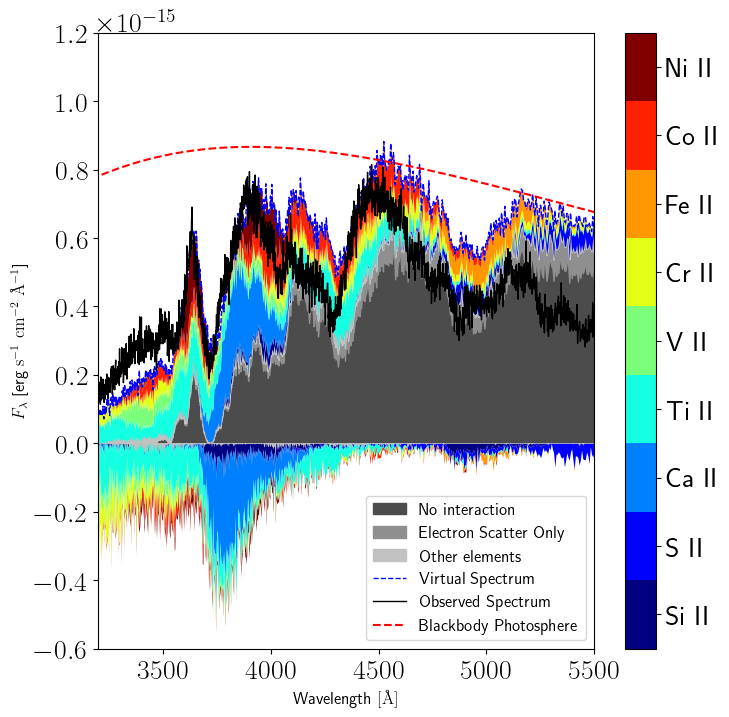

In [81]:
fig, ax = plt.subplots(figsize=(8, 8))
plotter1 = SDECPlotter.from_simulation(sim1)
# 2D SEDONA simulation
syn_dat = np.loadtxt("./Shen+2021/d14e5_mu_0_phase_2.5_spec.txt")
plotter1.generate_plot_mpl(
    packet_wvl_range=[3200, 5500] * u.AA,
    observed_spectrum=(
        syn_dat[:, 0] * u.AA,
        syn_dat[:, 1] * u.erg / u.cm**2 / u.s / u.AA / 4.5,
    ),
    # observed_spectrum=(
    #     joj2[:, 0] / (1 + z) * u.AA,
    #     joj2[:, 1] * (1 + z) * u.erg / u.cm**2 / u.s / u.AA / 4,
    # ),
    distance=114.48 * u.Mpc,
    species_list=["Si II", "S II", "Ca II", "Ti II", "V II", "Cr II", "Fe II", "Ni II", "Co II"],
    ax=ax
)
ax.legend(loc=4, prop={"size":12})
ax.set_ylim([-.6e-15, 1.2e-15])
ax.set_xlim(3200, 5500)
plt.show()

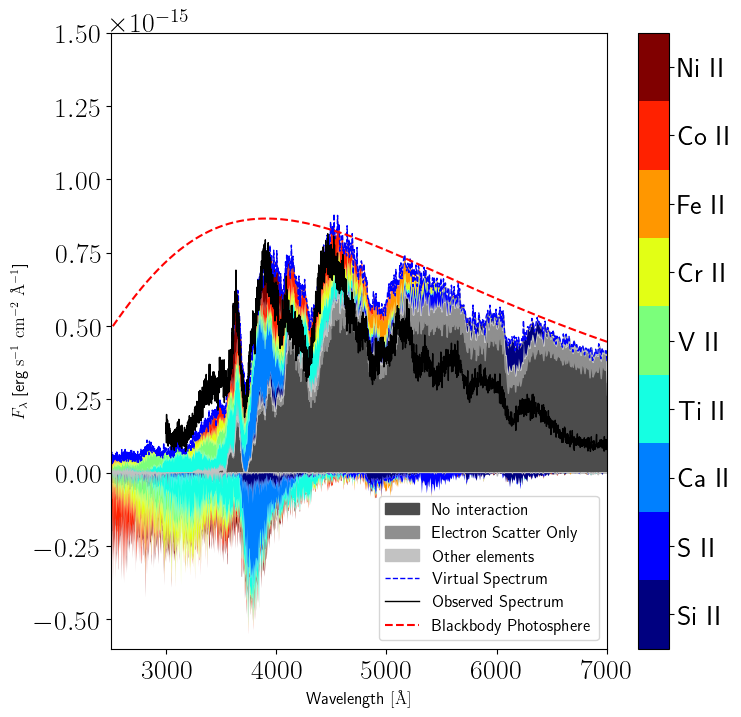

In [82]:
fig, ax = plt.subplots(figsize=(8, 8))
# 2D SEDONA simulation
syn_dat = np.loadtxt("./Shen+2021/d14e5_mu_0_phase_2.5_spec.txt")
plotter1.generate_plot_mpl(
    packet_wvl_range=[2500, 7000] * u.AA,
    observed_spectrum=(
        syn_dat[:, 0] * u.AA,
        syn_dat[:, 1] * u.erg / u.cm**2 / u.s / u.AA / 4.5,
    ),
    # observed_spectrum=(
    #     joj2[:, 0] / (1 + z) * u.AA,
    #     joj2[:, 1] * (1 + z) * u.erg / u.cm**2 / u.s / u.AA / 4,
    # ),
    distance=114.48 * u.Mpc,
    species_list=["Si II", "S II", "Ca II", "Ti II", "V II", "Cr II", "Fe II", "Ni II", "Co II"],
    ax=ax
)
ax.legend(loc=4, prop={"size":12})
ax.set_ylim([-.6e-15, 1.5e-15])
ax.set_xlim(2500, 7000)
plt.show()

## $\rho_5 = 6$

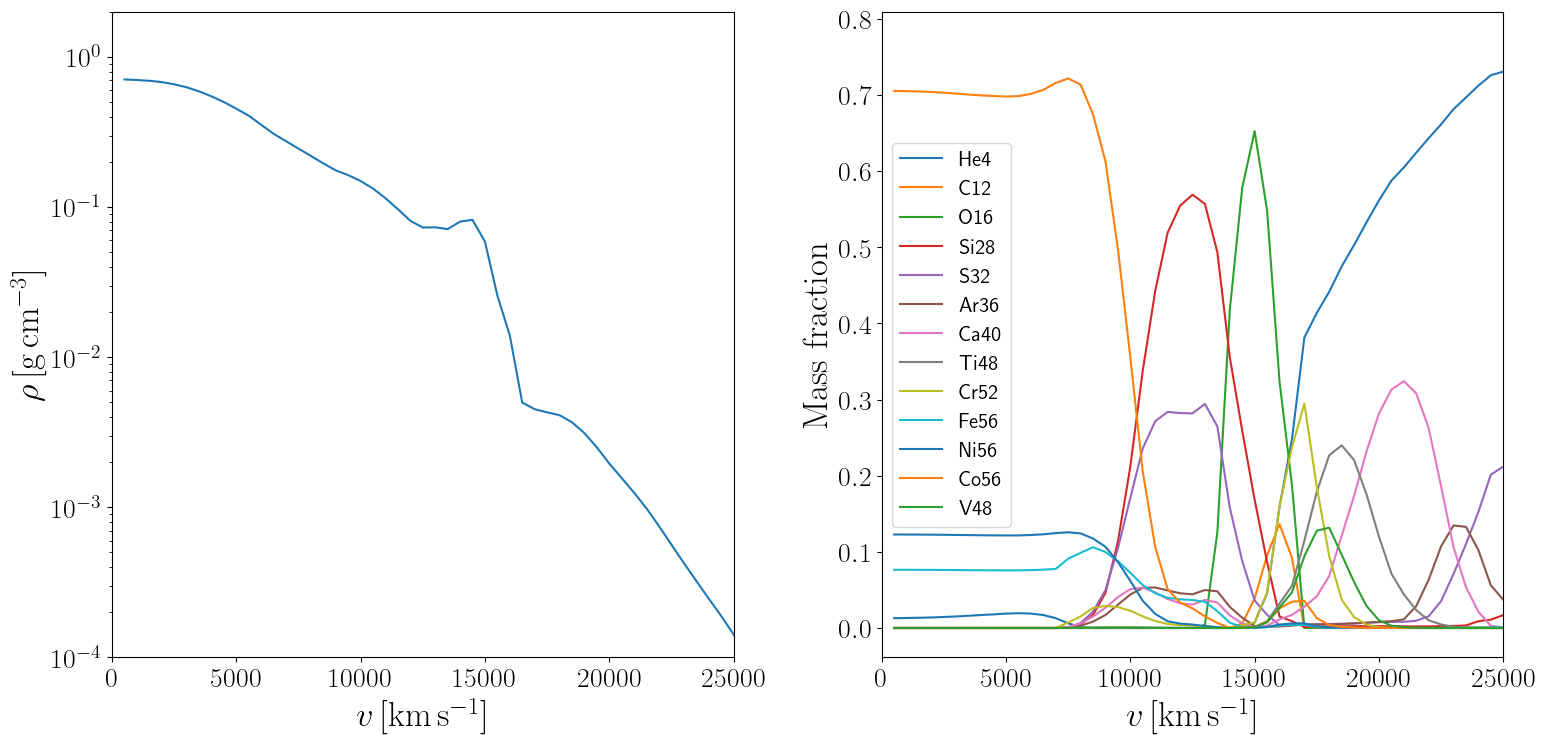

In [9]:
profile_6 = load_profile("./Shen+2021/d6e5_m100_wedge_mu_00.txt")
with open("./Shen+2021/d6e5_mu_0_phase_2.5_spec.txt") as f:
    l = f.readline()
    time = float(l.split("=")[-1])
    l = f.readline()
    log_L = float(l.split("=")[-1])

In [189]:
time

17.25

In [209]:
# with open("./Shen+2021/d6e5_mu_0_phase_0.0_spec.txt") as f:
#     l = f.readline()
#     time = float(l.split("=")[-1])
#     l = f.readline()
#     log_L = float(l.split("=")[-1])
# write_CSVY(
#     "./d6e5_mu00_Ti0",
#     isotopes=iso_title,
#     profile=profile_6,
#     time=time,
#     vmin=12000,
#     Ti_factor=0,
# )
# write_config(
#     fname="tardis_Ti0.yml", log_L=log_L - 0.45, time=time, csvy_model="d6e5_mu00_Ti0"
# )
# sim0 = run_tardis(
#     "tardis_Ti0.yml",
#     virtual_packet_logging=True,
#     show_convergence_plots=True,
#     export_convergence_plots=True,
#     log_level="INFO",
# )
# plotter0 = SDECPlotter.from_simulation(sim0)
write_CSVY(
    "./d6e5_mu00_Ti1",
    isotopes=iso_title,
    profile=profile_6,
    vmin=11300,
    Ti_factor=1,
)
write_config(
    fname="tardis_+2_Ti1.yml", log_L=log_L - 0.48, time=time, csvy_model="d6e5_mu00_Ti1"
)
sim1_d6 = run_tardis(
    "tardis_+2_Ti1.yml",
    virtual_packet_logging=True,
    show_convergence_plots=True,
    export_convergence_plots=True,
    log_level="INFO",
)
# plotter1 = SDECPlotter.from_simulation(sim1)

[tardis.model.base   ][WARNING]  
	Abundances have not been normalized to 1. - normalizing (base.py:892)
[tardis.plasma.standard_plasmas][INFO   ]  
	
	Reading Atomic Data from kurucz_cd23_chianti_H_He.h5 (standard_plasmas.py:95)
[tardis.io.atom_data.base][INFO   ]  
	Reading Atom Data with: UUID = 6f7b09e887a311e7a06b246e96350010 MD5  = 864f1753714343c41f99cb065710cace  (base.py:249)
[tardis.io.atom_data.base][INFO   ]  
	Non provided Atomic Data: synpp_refs, photoionization_data, yg_data, two_photon_data (base.py:253)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 1 of 30 (base.py:385)


TqdmHBox(children=(HTML(value='Packets:   ', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.331e+42 erg / s
	Luminosity absorbed  = 1.164e+42 erg / s
	Luminosity requested = 3.508e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,6.39e+03,6.9e+03,0.397,0.45
5,6.34e+03,6.76e+03,0.205,0.233
10,6.29e+03,5.91e+03,0.136,0.159
15,6.24e+03,4.88e+03,0.099,0.186
20,6.19e+03,4.51e+03,0.0756,0.178
25,6.14e+03,4.41e+03,0.0598,0.148
30,6.09e+03,4.36e+03,0.0486,0.124


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 6398.035 K
	Expected t_inner for next iteration = 6796.752 K
 (base.py:554)


    'data': [{'type': 'scatter', 'uid': '1fd0093e-7bc8-4216-bcb7-8faab619e07e', …

[tardis.simulation.base][INFO   ]  
	
	Starting iteration 2 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.443e+42 erg / s
	Luminosity absorbed  = 1.635e+42 erg / s
	Luminosity requested = 3.508e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,6.9e+03,7.33e+03,0.45,0.478
5,6.76e+03,7.25e+03,0.233,0.268
10,5.91e+03,6.52e+03,0.159,0.212
15,4.88e+03,5.4e+03,0.186,0.217
20,4.51e+03,4.52e+03,0.178,0.224
25,4.41e+03,4.26e+03,0.148,0.202
30,4.36e+03,4.17e+03,0.124,0.171


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 6796.752 K
	Expected t_inner for next iteration = 7176.825 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 3 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 2.062e+42 erg / s
	Luminosity absorbed  = 1.897e+42 erg / s
	Luminosity requested = 3.508e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,7.33e+03,7.78e+03,0.478,0.462
5,7.25e+03,7.65e+03,0.268,0.242
10,6.52e+03,7.08e+03,0.212,0.171
15,5.4e+03,6.01e+03,0.217,0.18
20,4.52e+03,4.95e+03,0.224,0.203
25,4.26e+03,4.63e+03,0.202,0.186
30,4.17e+03,4.53e+03,0.171,0.157


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7176.825 K
	Expected t_inner for next iteration = 7395.283 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 4 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 2.699e+42 erg / s
	Luminosity absorbed  = 1.796e+42 erg / s
	Luminosity requested = 3.508e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,7.78e+03,8.09e+03,0.462,0.43
5,7.65e+03,7.83e+03,0.242,0.218
10,7.08e+03,7.46e+03,0.171,0.139
15,6.01e+03,6.58e+03,0.18,0.138
20,4.95e+03,5.51e+03,0.203,0.161
25,4.63e+03,5.08e+03,0.186,0.155
30,4.53e+03,4.98e+03,0.157,0.132


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7395.283 K
	Expected t_inner for next iteration = 7498.815 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 5 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.085e+42 erg / s
	Luminosity absorbed  = 1.702e+42 erg / s
	Luminosity requested = 3.508e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.09e+03,8.25e+03,0.43,0.413
5,7.83e+03,7.82e+03,0.218,0.215
10,7.46e+03,7.22e+03,0.139,0.142
15,6.58e+03,6.51e+03,0.138,0.135
20,5.51e+03,5.81e+03,0.161,0.138
25,5.08e+03,5.48e+03,0.155,0.126
30,4.98e+03,5.34e+03,0.132,0.11


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7498.815 K
	Expected t_inner for next iteration = 7548.579 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 6 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.154e+42 erg / s
	Luminosity absorbed  = 1.737e+42 erg / s
	Luminosity requested = 3.508e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.25e+03,8.35e+03,0.413,0.409
5,7.82e+03,7.98e+03,0.215,0.212
10,7.22e+03,7.34e+03,0.142,0.142
15,6.51e+03,6.45e+03,0.135,0.139
20,5.81e+03,5.68e+03,0.138,0.149
25,5.48e+03,5.45e+03,0.126,0.131
30,5.34e+03,5.32e+03,0.11,0.113


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7548.579 K
	Expected t_inner for next iteration = 7589.786 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 7 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.235e+42 erg / s
	Luminosity absorbed  = 1.748e+42 erg / s
	Luminosity requested = 3.508e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.35e+03,8.47e+03,0.409,0.395
5,7.98e+03,8.17e+03,0.212,0.202
10,7.34e+03,7.53e+03,0.142,0.137
15,6.45e+03,6.74e+03,0.139,0.129
20,5.68e+03,5.78e+03,0.149,0.144
25,5.45e+03,5.49e+03,0.131,0.131
30,5.32e+03,5.37e+03,0.113,0.113


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7589.786 K
	Expected t_inner for next iteration = 7621.173 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 8 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.438e+42 erg / s
	Luminosity absorbed  = 1.645e+42 erg / s
	Luminosity requested = 3.508e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.47e+03,8.47e+03,0.395,0.399
5,8.17e+03,8.32e+03,0.202,0.189
10,7.53e+03,7.52e+03,0.137,0.135
15,6.74e+03,6.72e+03,0.129,0.129
20,5.78e+03,5.97e+03,0.144,0.134
25,5.49e+03,5.67e+03,0.131,0.121
30,5.37e+03,5.54e+03,0.113,0.105


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7621.173 K
	Expected t_inner for next iteration = 7628.894 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 9 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.441e+42 erg / s
	Luminosity absorbed  = 1.656e+42 erg / s
	Luminosity requested = 3.508e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 1/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.47e+03,8.5e+03,0.399,0.394
5,8.32e+03,8.35e+03,0.189,0.186
10,7.52e+03,7.63e+03,0.135,0.128
15,6.72e+03,6.65e+03,0.129,0.132
20,5.97e+03,5.91e+03,0.134,0.137
25,5.67e+03,5.68e+03,0.121,0.119
30,5.54e+03,5.56e+03,0.105,0.103


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7628.894 K
	Expected t_inner for next iteration = 7636.232 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 10 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.506e+42 erg / s
	Luminosity absorbed  = 1.611e+42 erg / s
	Luminosity requested = 3.508e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 2/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.5e+03,8.52e+03,0.394,0.391
5,8.35e+03,8.41e+03,0.186,0.184
10,7.63e+03,7.78e+03,0.128,0.125
15,6.65e+03,6.84e+03,0.132,0.125
20,5.91e+03,6e+03,0.137,0.132
25,5.68e+03,5.73e+03,0.119,0.118
30,5.56e+03,5.6e+03,0.103,0.102


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7636.232 K
	Expected t_inner for next iteration = 7636.401 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 11 of 30 (base.py:385)


TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.523e+42 erg / s
	Luminosity absorbed  = 1.586e+42 erg / s
	Luminosity requested = 3.508e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 3/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.52e+03,8.51e+03,0.391,0.388
5,8.41e+03,8.25e+03,0.184,0.19
10,7.78e+03,7.56e+03,0.125,0.131
15,6.84e+03,6.75e+03,0.125,0.127
20,6e+03,6e+03,0.132,0.132
25,5.73e+03,5.74e+03,0.118,0.117
30,5.6e+03,5.63e+03,0.102,0.101


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7636.401 K
	Expected t_inner for next iteration = 7634.723 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 12 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.495e+42 erg / s
	Luminosity absorbed  = 1.644e+42 erg / s
	Luminosity requested = 3.508e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 4/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.51e+03,8.56e+03,0.388,0.383
5,8.25e+03,8.37e+03,0.19,0.186
10,7.56e+03,7.61e+03,0.131,0.13
15,6.75e+03,6.58e+03,0.127,0.135
20,6e+03,5.95e+03,0.132,0.134
25,5.74e+03,5.72e+03,0.117,0.117
30,5.63e+03,5.6e+03,0.101,0.101


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7634.723 K
	Expected t_inner for next iteration = 7636.088 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 13 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.462e+42 erg / s
	Luminosity absorbed  = 1.626e+42 erg / s
	Luminosity requested = 3.508e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 5/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.56e+03,8.5e+03,0.383,0.392
5,8.37e+03,8.46e+03,0.186,0.181
10,7.61e+03,7.88e+03,0.13,0.121
15,6.58e+03,6.83e+03,0.135,0.125
20,5.95e+03,5.92e+03,0.134,0.138
25,5.72e+03,5.68e+03,0.117,0.121
30,5.6e+03,5.55e+03,0.101,0.105


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7636.088 K
	Expected t_inner for next iteration = 7641.087 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 14 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.526e+42 erg / s
	Luminosity absorbed  = 1.598e+42 erg / s
	Luminosity requested = 3.508e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 6/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.5e+03,8.51e+03,0.392,0.391
5,8.46e+03,8.36e+03,0.181,0.183
10,7.88e+03,7.69e+03,0.121,0.126
15,6.83e+03,6.78e+03,0.125,0.127
20,5.92e+03,6.02e+03,0.138,0.131
25,5.68e+03,5.75e+03,0.121,0.117
30,5.55e+03,5.64e+03,0.105,0.1


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7641.087 K
	Expected t_inner for next iteration = 7639.130 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 15 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.511e+42 erg / s
	Luminosity absorbed  = 1.627e+42 erg / s
	Luminosity requested = 3.508e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 7/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.51e+03,8.49e+03,0.391,0.393
5,8.36e+03,8.42e+03,0.183,0.181
10,7.69e+03,7.62e+03,0.126,0.129
15,6.78e+03,6.69e+03,0.127,0.129
20,6.02e+03,6.01e+03,0.131,0.129
25,5.75e+03,5.76e+03,0.117,0.115
30,5.64e+03,5.62e+03,0.1,0.1


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7639.130 K
	Expected t_inner for next iteration = 7638.721 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 16 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.502e+42 erg / s
	Luminosity absorbed  = 1.644e+42 erg / s
	Luminosity requested = 3.508e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 8/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.49e+03,8.49e+03,0.393,0.391
5,8.42e+03,8.46e+03,0.181,0.178
10,7.62e+03,7.81e+03,0.129,0.122
15,6.69e+03,6.75e+03,0.129,0.128
20,6.01e+03,6.01e+03,0.129,0.131
25,5.76e+03,5.75e+03,0.115,0.115
30,5.62e+03,5.65e+03,0.1,0.0984


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7638.721 K
	Expected t_inner for next iteration = 7639.276 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 17 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.506e+42 erg / s
	Luminosity absorbed  = 1.621e+42 erg / s
	Luminosity requested = 3.508e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 9/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.49e+03,8.5e+03,0.391,0.391
5,8.46e+03,8.33e+03,0.178,0.183
10,7.81e+03,7.78e+03,0.122,0.121
15,6.75e+03,6.76e+03,0.128,0.126
20,6.01e+03,6.05e+03,0.131,0.127
25,5.75e+03,5.79e+03,0.115,0.113
30,5.65e+03,5.66e+03,0.0984,0.0978


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7639.276 K
	Expected t_inner for next iteration = 7639.408 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 18 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.496e+42 erg / s
	Luminosity absorbed  = 1.625e+42 erg / s
	Luminosity requested = 3.508e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 10/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.5e+03,8.5e+03,0.391,0.388
5,8.33e+03,8.31e+03,0.183,0.187
10,7.78e+03,7.67e+03,0.121,0.126
15,6.76e+03,6.67e+03,0.126,0.13
20,6.05e+03,5.95e+03,0.127,0.135
25,5.79e+03,5.71e+03,0.113,0.119
30,5.66e+03,5.61e+03,0.0978,0.101


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7639.408 K
	Expected t_inner for next iteration = 7640.642 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 19 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.471e+42 erg / s
	Luminosity absorbed  = 1.641e+42 erg / s
	Luminosity requested = 3.508e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 11/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.5e+03,8.5e+03,0.388,0.395
5,8.31e+03,8.39e+03,0.187,0.183
10,7.67e+03,7.67e+03,0.126,0.127
15,6.67e+03,6.76e+03,0.13,0.127
20,5.95e+03,5.96e+03,0.135,0.134
25,5.71e+03,5.7e+03,0.119,0.119
30,5.61e+03,5.59e+03,0.101,0.101


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7640.642 K
	Expected t_inner for next iteration = 7644.606 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 20 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.518e+42 erg / s
	Luminosity absorbed  = 1.606e+42 erg / s
	Luminosity requested = 3.508e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 12/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.5e+03,8.52e+03,0.395,0.392
5,8.39e+03,8.33e+03,0.183,0.186
10,7.67e+03,7.59e+03,0.127,0.131
15,6.76e+03,6.72e+03,0.127,0.13
20,5.96e+03,5.99e+03,0.134,0.133
25,5.7e+03,5.75e+03,0.119,0.117
30,5.59e+03,5.62e+03,0.101,0.101


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7644.606 K
	Expected t_inner for next iteration = 7643.454 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 21 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.496e+42 erg / s
	Luminosity absorbed  = 1.666e+42 erg / s
	Luminosity requested = 3.508e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 13/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.52e+03,8.56e+03,0.392,0.382
5,8.33e+03,8.41e+03,0.186,0.18
10,7.59e+03,7.67e+03,0.131,0.129
15,6.72e+03,6.7e+03,0.13,0.13
20,5.99e+03,5.97e+03,0.133,0.133
25,5.75e+03,5.72e+03,0.117,0.118
30,5.62e+03,5.61e+03,0.101,0.101


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7643.454 K
	Expected t_inner for next iteration = 7644.759 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 22 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.540e+42 erg / s
	Luminosity absorbed  = 1.614e+42 erg / s
	Luminosity requested = 3.508e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 14/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.56e+03,8.53e+03,0.382,0.389
5,8.41e+03,8.46e+03,0.18,0.18
10,7.67e+03,7.78e+03,0.129,0.122
15,6.7e+03,6.85e+03,0.13,0.122
20,5.97e+03,6.06e+03,0.133,0.128
25,5.72e+03,5.77e+03,0.118,0.115
30,5.61e+03,5.65e+03,0.101,0.0988


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7644.759 K
	Expected t_inner for next iteration = 7641.273 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 23 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.539e+42 erg / s
	Luminosity absorbed  = 1.600e+42 erg / s
	Luminosity requested = 3.508e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 15/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.53e+03,8.49e+03,0.389,0.393
5,8.46e+03,8.47e+03,0.18,0.178
10,7.78e+03,7.62e+03,0.122,0.128
15,6.85e+03,6.79e+03,0.122,0.123
20,6.06e+03,6.06e+03,0.128,0.127
25,5.77e+03,5.78e+03,0.115,0.114
30,5.65e+03,5.66e+03,0.0988,0.0983


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7641.273 K
	Expected t_inner for next iteration = 7637.892 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 24 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.518e+42 erg / s
	Luminosity absorbed  = 1.617e+42 erg / s
	Luminosity requested = 3.508e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 16/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.49e+03,8.47e+03,0.393,0.394
5,8.47e+03,8.33e+03,0.178,0.186
10,7.62e+03,7.71e+03,0.128,0.125
15,6.79e+03,6.73e+03,0.123,0.127
20,6.06e+03,5.97e+03,0.127,0.134
25,5.78e+03,5.74e+03,0.114,0.117
30,5.66e+03,5.62e+03,0.0983,0.1


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7637.892 K
	Expected t_inner for next iteration = 7636.735 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 25 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.490e+42 erg / s
	Luminosity absorbed  = 1.649e+42 erg / s
	Luminosity requested = 3.508e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 17/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.47e+03,8.54e+03,0.394,0.385
5,8.33e+03,8.38e+03,0.186,0.183
10,7.71e+03,7.63e+03,0.125,0.128
15,6.73e+03,6.76e+03,0.127,0.126
20,5.97e+03,5.98e+03,0.134,0.133
25,5.74e+03,5.73e+03,0.117,0.117
30,5.62e+03,5.62e+03,0.1,0.0997


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7636.735 K
	Expected t_inner for next iteration = 7638.664 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 26 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.523e+42 erg / s
	Luminosity absorbed  = 1.616e+42 erg / s
	Luminosity requested = 3.508e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 18/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.54e+03,8.49e+03,0.385,0.394
5,8.38e+03,8.42e+03,0.183,0.182
10,7.63e+03,7.65e+03,0.128,0.129
15,6.76e+03,6.66e+03,0.126,0.133
20,5.98e+03,5.96e+03,0.133,0.135
25,5.73e+03,5.71e+03,0.117,0.12
30,5.62e+03,5.58e+03,0.0997,0.104


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7638.664 K
	Expected t_inner for next iteration = 7636.996 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 27 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.491e+42 erg / s
	Luminosity absorbed  = 1.624e+42 erg / s
	Luminosity requested = 3.508e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 19/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.49e+03,8.5e+03,0.394,0.392
5,8.42e+03,8.44e+03,0.182,0.179
10,7.65e+03,7.67e+03,0.129,0.128
15,6.66e+03,6.71e+03,0.133,0.13
20,5.96e+03,5.98e+03,0.135,0.132
25,5.71e+03,5.69e+03,0.12,0.12
30,5.58e+03,5.58e+03,0.104,0.103


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7636.996 K
	Expected t_inner for next iteration = 7638.765 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 28 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.523e+42 erg / s
	Luminosity absorbed  = 1.601e+42 erg / s
	Luminosity requested = 3.508e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 20/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.5e+03,8.5e+03,0.392,0.392
5,8.44e+03,8.35e+03,0.179,0.185
10,7.67e+03,7.7e+03,0.128,0.127
15,6.71e+03,6.72e+03,0.13,0.13
20,5.98e+03,5.95e+03,0.132,0.136
25,5.69e+03,5.68e+03,0.12,0.122
30,5.58e+03,5.58e+03,0.103,0.104


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7638.765 K
	Expected t_inner for next iteration = 7637.097 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 29 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.514e+42 erg / s
	Luminosity absorbed  = 1.627e+42 erg / s
	Luminosity requested = 3.508e+42 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 21/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,8.5e+03,8.52e+03,0.392,0.39
5,8.35e+03,8.33e+03,0.185,0.187
10,7.7e+03,7.61e+03,0.127,0.13
15,6.72e+03,6.8e+03,0.13,0.125
20,5.95e+03,5.98e+03,0.136,0.134
25,5.68e+03,5.72e+03,0.122,0.119
30,5.58e+03,5.6e+03,0.104,0.102


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 7637.097 K
	Expected t_inner for next iteration = 7636.353 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 30 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 3.489e+42 erg / s
	Luminosity absorbed  = 1.635e+42 erg / s
	Luminosity requested = 3.508e+42 erg / s
 (base.py:559)


[tardis.simulation.base][INFO   ]  
	
	Simulation finished in 30 iterations 
	Simulation took 216.39 s
 (base.py:480)


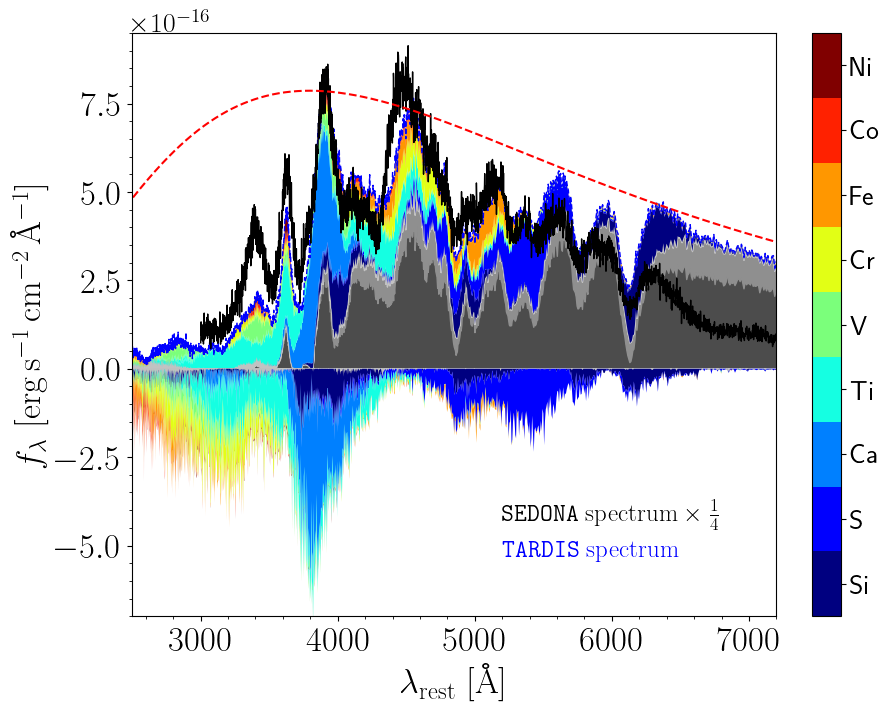

In [210]:
fig, ax = plt.subplots(figsize=(8.8, 7), constrained_layout=True)
plotter1 = SDECPlotter.from_simulation(sim1_d6)
# 2D SEDONA simulation
syn_dat = np.loadtxt("./Shen+2021/d6e5_mu_0_phase_2.5_spec.txt")
plotter1.generate_plot_mpl(
    packet_wvl_range=[2000, 9000] * u.AA,
    # show_modeled_spectrum=False,
    observed_spectrum=(
        syn_dat[:, 0] * u.AA,
        syn_dat[:, 1] * u.erg / u.cm**2 / u.s / u.AA / 4,
    ),
    # observed_spectrum=(
    #     joj2[:, 0] / (1 + z) * u.AA,
    #     joj2[:, 1] * (1 + z) * u.erg / u.cm**2 / u.s / u.AA / 4,
    # ),
    distance=114.48 * u.Mpc,
    # species_list=["Si II", "S II", "Ca II", "Ti II", "V II-III", "Cr II-III", "Fe II", "Co II", "Ni II"],
    species_list=["Si", "S", "Ca", "Ti", "V", "Cr", "Fe", "Co", "Ni"],
    # species_list=["Si", "S", "Ca", "Ti", "V", "Cr", "Fe"],
    ax=ax,
    # cmapname='turbo'
)
ax.legend(loc=4, prop={"size":12})
ax.set_ylim([-.7e-15, .95e-15])
ax.set_xlim(2500, 7200)
ax.set_xlabel(r"$\lambda_\mathrm{rest}\ [\mathrm{\r{A}}]$")
ax.set_ylabel(r"$f_\lambda\ [\mathrm{erg\,s^{-1}\,cm^{-2}\,\r{A}^{-1}}]$")
ax.xaxis.label.set_size(25)
ax.yaxis.label.set_size(25)
ax.tick_params(labelsize=25)
ax.get_legend().remove()

ax.xaxis.set_minor_locator(MultipleLocator(200))
ax.yaxis.set_minor_locator(MultipleLocator(0.5e-16))

ax.text(5200, -4.3e-16, r"$\texttt{SEDONA}\ \mathrm{spectrum}\times\frac14$", color="k", fontsize=18)
ax.text(5200, -5.3e-16, r"$\texttt{TARDIS}\ \mathrm{spectrum}$", color="b", fontsize=18)
plt.savefig("../paper/figures/TARDIS.pdf", bbox_inches='tight')

In [10]:
write_CSVY(
    "./d6e5_mu00_normal_L",
    isotopes=iso_title,
    profile=profile_6,
    vmin=10000,
)
write_config(
    fname="tardis_+2_normal_L.yml", log_L=log_L, time=time, csvy_model="d6e5_mu00_normal_L"
)
sim1_d6_L = run_tardis(
    "tardis_+2_normal_L.yml",
    virtual_packet_logging=True,
    show_convergence_plots=True,
    export_convergence_plots=True,
    log_level="INFO",
)

[tardis.model.base   ][WARNING]  
	Abundances have not been normalized to 1. - normalizing (base.py:892)
[tardis.plasma.standard_plasmas][INFO   ]  
	
	Reading Atomic Data from kurucz_cd23_chianti_H_He.h5 (standard_plasmas.py:95)
[tardis.io.atom_data.base][INFO   ]  
	Reading Atom Data with: UUID = 6f7b09e887a311e7a06b246e96350010 MD5  = 864f1753714343c41f99cb065710cace  (base.py:249)
[tardis.io.atom_data.base][INFO   ]  
	Non provided Atomic Data: synpp_refs, photoionization_data, yg_data, two_photon_data (base.py:253)
[py.warnings         ][WARNING]  
	/Users/chang/miniconda3/envs/tardis/lib/python3.8/site-packages/tardis/plasma/properties/radiative_properties.py:93: RuntimeWarning: invalid value encountered in true_divide
  (g_lower * n_upper) / (g_upper * n_lower)
 (warnings.py:109)


OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


[py.warnings         ][WARNING]  
	/Users/chang/miniconda3/envs/tardis/lib/python3.8/site-packages/tardis/plasma/properties/radiative_properties.py:93: RuntimeWarning: invalid value encountered in true_divide
  (g_lower * n_upper) / (g_upper * n_lower)
 (warnings.py:109)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 1 of 30 (base.py:385)


TqdmHBox(children=(HTML(value='Iterations:', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

TqdmHBox(children=(HTML(value='Packets:   ', layout=Layout(width='6%')), FloatProgress(value=0.0, layout=Layou…

[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 4.261e+42 erg / s
	Luminosity absorbed  = 2.981e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.04e+03,9.5e+03,0.39,0.507
5,8.96e+03,8.89e+03,0.19,0.248
10,8.89e+03,8.75e+03,0.123,0.122
15,8.82e+03,7.39e+03,0.0869,0.123
20,8.75e+03,6.51e+03,0.0652,0.13
25,8.68e+03,6.3e+03,0.0509,0.109
30,8.61e+03,6.21e+03,0.0409,0.0904
35,8.54e+03,6.12e+03,0.0336,0.0768


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9044.728 K
	Expected t_inner for next iteration = 9566.345 K
 (base.py:554)
[py.warnings         ][WARNING]  
	/Users/chang/miniconda3/envs/tardis/lib/python3.8/site-packages/tardis/plasma/properties/radiative_properties.py:93: RuntimeWarning: invalid value encountered in true_divide
  (g_lower * n_upper) / (g_upper * n_lower)
 (warnings.py:109)


    'data': [{'type': 'scatter', 'uid': '0b600d6b-5042-4bf2-9618-76ac48485ff5', …

[tardis.simulation.base][INFO   ]  
	
	Starting iteration 2 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 5.136e+42 erg / s
	Luminosity absorbed  = 3.723e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,9.5e+03,1.01e+04,0.507,0.523
5,8.89e+03,9.22e+03,0.248,0.281
10,8.75e+03,9.41e+03,0.122,0.131
15,7.39e+03,8.21e+03,0.123,0.122
20,6.51e+03,6.84e+03,0.13,0.136
25,6.3e+03,6.33e+03,0.109,0.129
30,6.21e+03,6.17e+03,0.0904,0.11
35,6.12e+03,6.08e+03,0.0768,0.0935


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9566.345 K
	Expected t_inner for next iteration = 9983.565 K
 (base.py:554)
[py.warnings         ][WARNING]  
	/Users/chang/miniconda3/envs/tardis/lib/python3.8/site-packages/tardis/plasma/properties/radiative_properties.py:93: RuntimeWarning:

invalid value encountered in true_divide

 (warnings.py:109)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 3 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 6.109e+42 erg / s
	Luminosity absorbed  = 4.040e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.01e+04,1.05e+04,0.523,0.514
5,9.22e+03,9.56e+03,0.281,0.283
10,9.41e+03,9.8e+03,0.131,0.128
15,8.21e+03,8.35e+03,0.122,0.122
20,6.84e+03,7.29e+03,0.136,0.126
25,6.33e+03,6.77e+03,0.129,0.118
30,6.17e+03,6.56e+03,0.11,0.102
35,6.08e+03,6.47e+03,0.0935,0.0869


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 9983.565 K
	Expected t_inner for next iteration = 10299.860 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 4 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 6.944e+42 erg / s
	Luminosity absorbed  = 4.162e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.05e+04,1.1e+04,0.514,0.487
5,9.56e+03,9.9e+03,0.283,0.281
10,9.8e+03,1.02e+04,0.128,0.125
15,8.35e+03,8.63e+03,0.122,0.12
20,7.29e+03,7.44e+03,0.126,0.128
25,6.77e+03,7.02e+03,0.118,0.114
30,6.56e+03,6.87e+03,0.102,0.0966
35,6.47e+03,6.77e+03,0.0869,0.0824


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10299.860 K
	Expected t_inner for next iteration = 10542.030 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 5 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 7.594e+42 erg / s
	Luminosity absorbed  = 4.451e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.1e+04,1.13e+04,0.487,0.484
5,9.9e+03,1.02e+04,0.281,0.271
10,1.02e+04,1.06e+04,0.125,0.124
15,8.63e+03,8.86e+03,0.12,0.118
20,7.44e+03,7.56e+03,0.128,0.129
25,7.02e+03,7.18e+03,0.114,0.114
30,6.87e+03,7.03e+03,0.0966,0.096
35,6.77e+03,6.92e+03,0.0824,0.0817


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10542.030 K
	Expected t_inner for next iteration = 10732.896 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 6 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 8.054e+42 erg / s
	Luminosity absorbed  = 4.537e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.13e+04,1.16e+04,0.484,0.476
5,1.02e+04,1.06e+04,0.271,0.255
10,1.06e+04,1.08e+04,0.124,0.122
15,8.86e+03,8.97e+03,0.118,0.122
20,7.56e+03,7.68e+03,0.129,0.129
25,7.18e+03,7.28e+03,0.114,0.115
30,7.03e+03,7.11e+03,0.096,0.0978
35,6.92e+03,7e+03,0.0817,0.0837


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10732.896 K
	Expected t_inner for next iteration = 10890.473 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 7 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 8.426e+42 erg / s
	Luminosity absorbed  = 4.755e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.16e+04,1.18e+04,0.476,0.466
5,1.06e+04,1.09e+04,0.255,0.247
10,1.08e+04,1.11e+04,0.122,0.119
15,8.97e+03,9.09e+03,0.122,0.122
20,7.68e+03,7.71e+03,0.129,0.133
25,7.28e+03,7.32e+03,0.115,0.117
30,7.11e+03,7.18e+03,0.0978,0.0986
35,7e+03,7.09e+03,0.0837,0.0836


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 10890.473 K
	Expected t_inner for next iteration = 11022.485 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 8 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 8.662e+42 erg / s
	Luminosity absorbed  = 4.914e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.18e+04,1.2e+04,0.466,0.458
5,1.09e+04,1.12e+04,0.247,0.238
10,1.11e+04,1.13e+04,0.119,0.117
15,9.09e+03,9.23e+03,0.122,0.118
20,7.71e+03,7.76e+03,0.133,0.133
25,7.32e+03,7.4e+03,0.117,0.116
30,7.18e+03,7.25e+03,0.0986,0.0981
35,7.09e+03,7.13e+03,0.0836,0.0841


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 11022.485 K
	Expected t_inner for next iteration = 11139.154 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 9 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 8.945e+42 erg / s
	Luminosity absorbed  = 5.144e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.2e+04,1.22e+04,0.458,0.45
5,1.12e+04,1.14e+04,0.238,0.228
10,1.13e+04,1.15e+04,0.117,0.113
15,9.23e+03,9.21e+03,0.118,0.122
20,7.76e+03,7.81e+03,0.133,0.134
25,7.4e+03,7.46e+03,0.116,0.116
30,7.25e+03,7.29e+03,0.0981,0.0982
35,7.13e+03,7.18e+03,0.0841,0.0836


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 11139.154 K
	Expected t_inner for next iteration = 11237.449 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 10 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 9.182e+42 erg / s
	Luminosity absorbed  = 5.233e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.22e+04,1.23e+04,0.45,0.453
5,1.14e+04,1.15e+04,0.228,0.229
10,1.15e+04,1.17e+04,0.113,0.113
15,9.21e+03,9.24e+03,0.122,0.125
20,7.81e+03,7.74e+03,0.134,0.141
25,7.46e+03,7.39e+03,0.116,0.123
30,7.29e+03,7.26e+03,0.0982,0.103
35,7.18e+03,7.15e+03,0.0836,0.0877


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 11237.449 K
	Expected t_inner for next iteration = 11320.694 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 11 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 9.267e+42 erg / s
	Luminosity absorbed  = 5.450e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.23e+04,1.25e+04,0.453,0.448
5,1.15e+04,1.17e+04,0.229,0.223
10,1.17e+04,1.17e+04,0.113,0.113
15,9.24e+03,9.31e+03,0.125,0.123
20,7.74e+03,7.83e+03,0.141,0.138
25,7.39e+03,7.42e+03,0.123,0.123
30,7.26e+03,7.28e+03,0.103,0.103
35,7.15e+03,7.19e+03,0.0877,0.0872


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 11320.694 K
	Expected t_inner for next iteration = 11398.978 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 12 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 9.313e+42 erg / s
	Luminosity absorbed  = 5.596e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.25e+04,1.27e+04,0.448,0.438
5,1.17e+04,1.18e+04,0.223,0.22
10,1.17e+04,1.17e+04,0.113,0.113
15,9.31e+03,9.27e+03,0.123,0.124
20,7.83e+03,7.81e+03,0.138,0.139
25,7.42e+03,7.46e+03,0.123,0.121
30,7.28e+03,7.31e+03,0.103,0.102
35,7.19e+03,7.2e+03,0.0872,0.0867


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 11398.978 K
	Expected t_inner for next iteration = 11474.786 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 13 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 9.390e+42 erg / s
	Luminosity absorbed  = 5.791e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.27e+04,1.28e+04,0.438,0.44
5,1.18e+04,1.19e+04,0.22,0.219
10,1.17e+04,1.19e+04,0.113,0.11
15,9.27e+03,9.33e+03,0.124,0.125
20,7.81e+03,7.87e+03,0.139,0.138
25,7.46e+03,7.49e+03,0.121,0.121
30,7.31e+03,7.34e+03,0.102,0.102
35,7.2e+03,7.22e+03,0.0867,0.0869


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 11474.786 K
	Expected t_inner for next iteration = 11546.090 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 14 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 9.631e+42 erg / s
	Luminosity absorbed  = 5.791e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 1/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.28e+04,1.28e+04,0.44,0.443
5,1.19e+04,1.21e+04,0.219,0.215
10,1.19e+04,1.22e+04,0.11,0.106
15,9.33e+03,9.49e+03,0.125,0.12
20,7.87e+03,7.95e+03,0.138,0.137
25,7.49e+03,7.55e+03,0.121,0.12
30,7.34e+03,7.4e+03,0.102,0.101
35,7.22e+03,7.28e+03,0.0869,0.0862


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 11546.090 K
	Expected t_inner for next iteration = 11602.379 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 15 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 9.657e+42 erg / s
	Luminosity absorbed  = 5.988e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 2/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.28e+04,1.29e+04,0.443,0.44
5,1.21e+04,1.21e+04,0.215,0.219
10,1.22e+04,1.23e+04,0.106,0.102
15,9.49e+03,9.5e+03,0.12,0.12
20,7.95e+03,8.02e+03,0.137,0.133
25,7.55e+03,7.63e+03,0.12,0.116
30,7.4e+03,7.46e+03,0.101,0.0982
35,7.28e+03,7.36e+03,0.0862,0.0831


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 11602.379 K
	Expected t_inner for next iteration = 11657.303 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 16 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 9.698e+42 erg / s
	Luminosity absorbed  = 6.155e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 3/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.29e+04,1.3e+04,0.44,0.435
5,1.21e+04,1.22e+04,0.219,0.21
10,1.23e+04,1.24e+04,0.102,0.101
15,9.5e+03,9.66e+03,0.12,0.116
20,8.02e+03,8.03e+03,0.133,0.132
25,7.63e+03,7.65e+03,0.116,0.115
30,7.46e+03,7.48e+03,0.0982,0.0974
35,7.36e+03,7.36e+03,0.0831,0.0832


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 11657.303 K
	Expected t_inner for next iteration = 11709.914 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 17 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 9.693e+42 erg / s
	Luminosity absorbed  = 6.179e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 4/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.3e+04,1.32e+04,0.435,0.429
5,1.22e+04,1.22e+04,0.21,0.212
10,1.24e+04,1.23e+04,0.101,0.102
15,9.66e+03,9.76e+03,0.116,0.113
20,8.03e+03,8.13e+03,0.132,0.128
25,7.65e+03,7.65e+03,0.115,0.116
30,7.48e+03,7.51e+03,0.0974,0.0973
35,7.36e+03,7.38e+03,0.0832,0.0834


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 11709.914 K
	Expected t_inner for next iteration = 11763.031 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 18 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 9.944e+42 erg / s
	Luminosity absorbed  = 6.184e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 5/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.32e+04,1.32e+04,0.429,0.429
5,1.22e+04,1.22e+04,0.212,0.213
10,1.23e+04,1.24e+04,0.102,0.103
15,9.76e+03,9.75e+03,0.113,0.115
20,8.13e+03,8.02e+03,0.128,0.137
25,7.65e+03,7.64e+03,0.116,0.119
30,7.51e+03,7.49e+03,0.0973,0.1
35,7.38e+03,7.38e+03,0.0834,0.0851


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 11763.031 K
	Expected t_inner for next iteration = 11800.767 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 19 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 9.899e+42 erg / s
	Luminosity absorbed  = 6.297e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 6/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.32e+04,1.32e+04,0.429,0.436
5,1.22e+04,1.22e+04,0.213,0.216
10,1.24e+04,1.25e+04,0.103,0.101
15,9.75e+03,9.88e+03,0.115,0.111
20,8.02e+03,8.06e+03,0.137,0.135
25,7.64e+03,7.69e+03,0.119,0.117
30,7.49e+03,7.54e+03,0.1,0.0978
35,7.38e+03,7.43e+03,0.0851,0.0834


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 11800.767 K
	Expected t_inner for next iteration = 11841.431 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 20 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.000e+43 erg / s
	Luminosity absorbed  = 6.427e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 7/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.32e+04,1.33e+04,0.436,0.441
5,1.22e+04,1.24e+04,0.216,0.215
10,1.25e+04,1.25e+04,0.101,0.102
15,9.88e+03,9.83e+03,0.111,0.114
20,8.06e+03,8.03e+03,0.135,0.139
25,7.69e+03,7.66e+03,0.117,0.12
30,7.54e+03,7.5e+03,0.0978,0.101
35,7.43e+03,7.4e+03,0.0834,0.0858


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 11841.431 K
	Expected t_inner for next iteration = 11875.961 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 21 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.019e+43 erg / s
	Luminosity absorbed  = 6.476e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 8/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.33e+04,1.33e+04,0.441,0.438
5,1.24e+04,1.26e+04,0.215,0.207
10,1.25e+04,1.27e+04,0.102,0.101
15,9.83e+03,9.91e+03,0.114,0.113
20,8.03e+03,8.17e+03,0.139,0.132
25,7.66e+03,7.79e+03,0.12,0.114
30,7.5e+03,7.6e+03,0.101,0.097
35,7.4e+03,7.49e+03,0.0858,0.0825


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 11875.961 K
	Expected t_inner for next iteration = 11899.350 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 22 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.012e+43 erg / s
	Luminosity absorbed  = 6.456e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 9/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.33e+04,1.34e+04,0.438,0.434
5,1.26e+04,1.26e+04,0.207,0.208
10,1.27e+04,1.27e+04,0.101,0.0981
15,9.91e+03,1.01e+04,0.113,0.107
20,8.17e+03,8.23e+03,0.132,0.129
25,7.79e+03,7.76e+03,0.114,0.115
30,7.6e+03,7.6e+03,0.097,0.0971
35,7.49e+03,7.49e+03,0.0825,0.0826


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 11899.350 K
	Expected t_inner for next iteration = 11926.880 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 23 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.006e+43 erg / s
	Luminosity absorbed  = 6.555e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 10/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.34e+04,1.34e+04,0.434,0.444
5,1.26e+04,1.27e+04,0.208,0.208
10,1.27e+04,1.28e+04,0.0981,0.0964
15,1.01e+04,1.02e+04,0.107,0.104
20,8.23e+03,8.23e+03,0.129,0.129
25,7.76e+03,7.81e+03,0.115,0.113
30,7.6e+03,7.64e+03,0.0971,0.0953
35,7.49e+03,7.53e+03,0.0826,0.0808


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 11926.880 K
	Expected t_inner for next iteration = 11957.824 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 24 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.029e+43 erg / s
	Luminosity absorbed  = 6.681e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 11/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.34e+04,1.34e+04,0.444,0.441
5,1.27e+04,1.27e+04,0.208,0.207
10,1.28e+04,1.29e+04,0.0964,0.0953
15,1.02e+04,1.03e+04,0.104,0.103
20,8.23e+03,8.28e+03,0.129,0.128
25,7.81e+03,7.83e+03,0.113,0.114
30,7.64e+03,7.66e+03,0.0953,0.0956
35,7.53e+03,7.55e+03,0.0808,0.0813


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 11957.824 K
	Expected t_inner for next iteration = 11975.454 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 25 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.015e+43 erg / s
	Luminosity absorbed  = 6.611e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 12/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.34e+04,1.35e+04,0.441,0.433
5,1.27e+04,1.26e+04,0.207,0.209
10,1.29e+04,1.3e+04,0.0953,0.094
15,1.03e+04,1.04e+04,0.103,0.101
20,8.28e+03,8.32e+03,0.128,0.125
25,7.83e+03,7.88e+03,0.114,0.111
30,7.66e+03,7.7e+03,0.0956,0.094
35,7.55e+03,7.58e+03,0.0813,0.0799


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 11975.454 K
	Expected t_inner for next iteration = 12001.141 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 26 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.027e+43 erg / s
	Luminosity absorbed  = 6.611e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 13/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.35e+04,1.35e+04,0.433,0.433
5,1.26e+04,1.27e+04,0.209,0.208
10,1.3e+04,1.3e+04,0.094,0.0934
15,1.04e+04,1.05e+04,0.101,0.0992
20,8.32e+03,8.37e+03,0.125,0.125
25,7.88e+03,7.88e+03,0.111,0.112
30,7.7e+03,7.71e+03,0.094,0.0949
35,7.58e+03,7.58e+03,0.0799,0.0813


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 12001.141 K
	Expected t_inner for next iteration = 12019.841 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 27 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.023e+43 erg / s
	Luminosity absorbed  = 6.686e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 14/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.35e+04,1.35e+04,0.433,0.435
5,1.27e+04,1.27e+04,0.208,0.208
10,1.3e+04,1.3e+04,0.0934,0.0911
15,1.05e+04,1.04e+04,0.0992,0.101
20,8.37e+03,8.35e+03,0.125,0.124
25,7.88e+03,7.92e+03,0.112,0.11
30,7.71e+03,7.74e+03,0.0949,0.0926
35,7.58e+03,7.62e+03,0.0813,0.079


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 12019.841 K
	Expected t_inner for next iteration = 12040.857 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 28 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.051e+43 erg / s
	Luminosity absorbed  = 6.779e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.35e+04,1.35e+04,0.435,0.444
5,1.27e+04,1.26e+04,0.208,0.216
10,1.3e+04,1.3e+04,0.0911,0.0945
15,1.04e+04,1.03e+04,0.101,0.107
20,8.35e+03,8.26e+03,0.124,0.132
25,7.92e+03,7.86e+03,0.11,0.115
30,7.74e+03,7.68e+03,0.0926,0.0975
35,7.62e+03,7.56e+03,0.079,0.0833


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 12040.857 K
	Expected t_inner for next iteration = 12045.556 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 29 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.040e+43 erg / s
	Luminosity absorbed  = 6.783e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)
[tardis.simulation.base][INFO   ]  
	Iteration converged 1/4 consecutive times. (base.py:266)
[tardis.simulation.base][INFO   ]  
	
	Plasma stratification: (base.py:527)


Shell No.,t_rad,next_t_rad,w,next_w
0,1.35e+04,1.35e+04,0.444,0.445
5,1.26e+04,1.26e+04,0.216,0.216
10,1.3e+04,1.29e+04,0.0945,0.0947
15,1.03e+04,1.03e+04,0.107,0.105
20,8.26e+03,8.34e+03,0.132,0.128
25,7.86e+03,7.91e+03,0.115,0.112
30,7.68e+03,7.75e+03,0.0975,0.0938
35,7.56e+03,7.58e+03,0.0833,0.0818


[tardis.simulation.base][INFO   ]  
	
	Current t_inner = 12045.556 K
	Expected t_inner for next iteration = 12056.651 K
 (base.py:554)
[tardis.simulation.base][INFO   ]  
	
	Starting iteration 30 of 30 (base.py:385)
[tardis.simulation.base][INFO   ]  
	
	Luminosity emitted   = 1.033e+43 erg / s
	Luminosity absorbed  = 6.851e+42 erg / s
	Luminosity requested = 1.059e+43 erg / s
 (base.py:559)


[tardis.simulation.base][INFO   ]  
	
	Simulation finished in 30 iterations 
	Simulation took 382.92 s
 (base.py:480)


[py.warnings         ][WARNING]  
	/Users/chang/miniconda3/envs/tardis/lib/python3.8/site-packages/astropy/units/quantity.py:1247: AstropyDeprecationWarning:

The truth value of a Quantity is ambiguous. In the future this will raise a ValueError.

 (warnings.py:109)


Text(5200, -1.5e-15, '$\\texttt{TARDIS}\\ \\mathrm{spectrum}$')

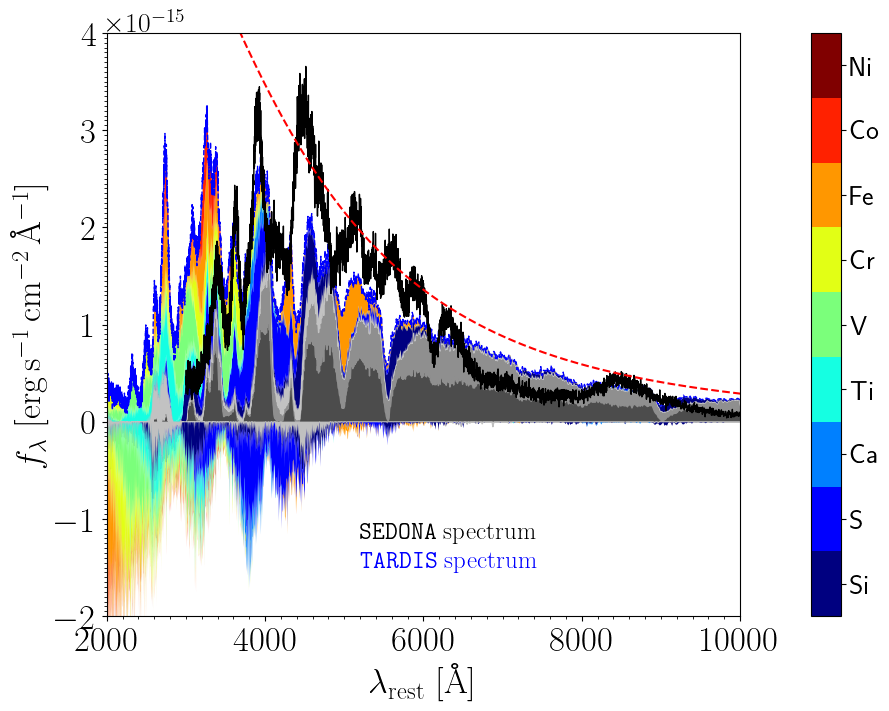

In [11]:
fig, ax = plt.subplots(figsize=(8.8, 7), constrained_layout=True)
plotter1 = SDECPlotter.from_simulation(sim1_d6_L)
# 2D SEDONA simulation
syn_dat = np.loadtxt("./Shen+2021/d6e5_mu_0_phase_2.5_spec.txt")
plotter1.generate_plot_mpl(
    packet_wvl_range=[2000, 10000] * u.AA,
    # show_modeled_spectrum=False,
    observed_spectrum=(
        syn_dat[:, 0] * u.AA,
        syn_dat[:, 1] * u.erg / u.cm**2 / u.s / u.AA,
    ),
    # observed_spectrum=(
    #     joj2[:, 0] / (1 + z) * u.AA,
    #     joj2[:, 1] * (1 + z) * u.erg / u.cm**2 / u.s / u.AA / 4,
    # ),
    distance=114.48 * u.Mpc,
    # species_list=["Si II", "S II", "Ca II", "Ti II", "V II-III", "Cr II-III", "Fe II", "Co II", "Ni II"],
    species_list=["Si", "S", "Ca", "Ti", "V", "Cr", "Fe", "Co", "Ni"],
    # species_list=["Si", "S", "Ca", "Ti", "V", "Cr", "Fe"],
    ax=ax,
    # cmapname='turbo'
)
ax.legend(loc=4, prop={"size":12})
ax.set_ylim([-2e-15, 4e-15])
ax.set_xlim(2000, 10000)
ax.set_xlabel(r"$\lambda_\mathrm{rest}\ [\mathrm{\r{A}}]$")
ax.set_ylabel(r"$f_\lambda\ [\mathrm{erg\,s^{-1}\,cm^{-2}\,\r{A}^{-1}}]$")
ax.xaxis.label.set_size(25)
ax.yaxis.label.set_size(25)
ax.tick_params(labelsize=25)
ax.get_legend().remove()

ax.xaxis.set_minor_locator(MultipleLocator(200))
ax.yaxis.set_minor_locator(MultipleLocator(0.5e-16))

ax.text(5200, -12e-16, r"$\texttt{SEDONA}\ \mathrm{spectrum}$", color="k", fontsize=18)
ax.text(5200, -15e-16, r"$\texttt{TARDIS}\ \mathrm{spectrum}$", color="b", fontsize=18)
# plt.savefig("../paper/figures/TARDIS.pdf", bbox_inches='tight')